**Instal libraries**

In [1]:
#!pip install scanpy
#!pip install muon 
#!pip install gseapy
#!pip install adjustText
#!pip install anndata

In [2]:
#!pip install PyPDF2

In [3]:
import scanpy as sc
import muon as mu
import time
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit, fsolve, least_squares

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import sys
from contextlib import contextmanager
import gseapy as gp
import gc
import networkx as nx

from decimal import Decimal, getcontext


/home/hruzko/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load data**

In [4]:
def load_data():
    load_start_time = time.time()
    adata = mu.read("Satija.h5mu")
    print("----Data successfully loaded in %d seconds----" % (time.time() - load_start_time))
    return adata

full_data = load_data()


/home/hruzko/miniconda3/envs/MAD_safe_version/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/hruzko/miniconda3/envs/MAD_safe_version/lib/python3.10/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/hruzko/miniconda3/envs/MAD_safe_version/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs

----Data successfully loaded in 67 seconds----


**View data**

In [5]:
with mu.set_options(display_style="html", display_html_expand=0b00000):
    display(full_data)

nCount_ADT,float64,"7430.00,5949.00,6547.00,3508.00,6318.00,5195.00,75..."
nFeature_ADT,int32,"221,211,217,207,219,213,223,226,205,210,216,212,21..."
nCount_RNA,float64,"10823.00,5864.00,5067.00,4786.00,6505.00,4332.00,9..."
nFeature_RNA,int32,"2915,1617,1381,1890,1621,1633,2672,1122,1375,1200,..."
orig.ident,object,"P2_7,P1_7,P4_3,P3_7,P4_7,P3_3,P1_7,P4_3,P1_3,P3_3,..."
lane,object,"L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1,L1..."
donor,object,"P2,P1,P4,P3,P4,P3,P1,P4,P1,P3,P3,P1,P2,P2,P4,P1,P3..."
time,object,"7,7,3,7,7,3,7,3,3,3,0,0,3,3,0,0,7,7,7,0,3,3,7,0,7,..."
celltype.l1,object,"Mono,CD4 T,CD8 T,NK,CD8 T,CD8 T,Mono,B,NK,CD8 T,CD..."
celltype.l2,object,"CD14 Mono,CD4 TCM,CD8 Naive,NK,CD8 Naive,CD8 TEM,C..."
celltype.l3,object,"CD14 Mono,CD4 TCM_1,CD8 Naive,NK_2,CD8 Naive,CD8 T..."


Source links: '\n'
https://github.com/scverse/muon-tutorials/blob/master/cite-seq/1-CITE-seq-PBMC-5k.ipynb '\n'
https://github.com/scverse/muon-tutorials/blob/master/cite-seq/2-CITE-seq-PBMC-5k-Weighted-Neighbours.ipynb '\n'
https://www.sc-best-practices.org/introduction/analysis_tools.html '\n'
https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html '\n'

**Create histogram**

(array([7.3000e+01, 1.0000e+00, 2.9000e+01, 1.1200e+02, 7.1000e+01,
        1.2000e+02, 2.5900e+02, 4.7700e+02, 1.0540e+03, 1.9890e+03,
        3.6960e+03, 6.2100e+03, 9.1090e+03, 1.1899e+04, 1.4720e+04,
        1.6288e+04, 1.7021e+04, 1.6082e+04, 1.4818e+04, 1.2835e+04,
        9.7540e+03, 7.0910e+03, 4.6460e+03, 3.0520e+03, 1.9770e+03,
        1.4800e+03, 1.1470e+03, 9.6000e+02, 8.8100e+02, 7.3100e+02,
        5.8400e+02, 4.7000e+02, 4.3400e+02, 3.1300e+02, 2.7100e+02,
        2.1300e+02, 1.9200e+02, 1.2300e+02, 1.0000e+02, 9.2000e+01,
        5.7000e+01, 6.6000e+01, 3.8000e+01, 2.8000e+01, 3.3000e+01,
        1.9000e+01, 1.7000e+01, 1.2000e+01, 8.0000e+00, 1.4000e+01,
        1.2000e+01, 5.0000e+00, 7.0000e+00, 4.0000e+00, 8.0000e+00,
        6.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.00

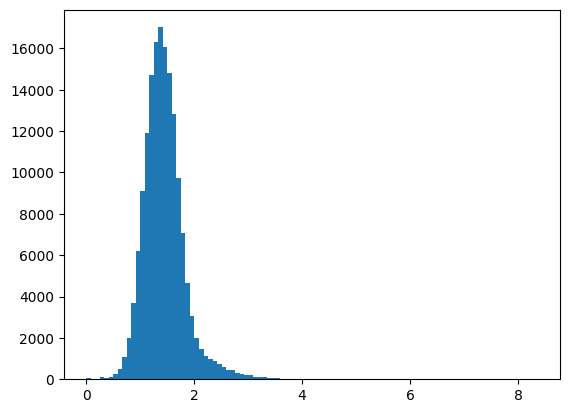

In [6]:
adata = full_data['ADT']
#print(adata.var.index == 'CD57')
plt.hist(adata.X[: ,adata.var.index == 'CD57'], bins = 100)


**Tasks**
- divide dataset by people
- divide dataset by cells
 - interesting proteins
 - treshold
     - methods to subset with gausians - proteins - fitting distribution by gaussians  
     - find in article or by the gating paper how to categorize cell gates 

**Gaussians threshold**
 - https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of
 - I have no idea how this works
 - It just does
 - And looks cool

              params       sigma
mu1         1.383402    0.002694
sigma1      0.296196    0.002108
A1      16954.646717  184.776490
mu2         2.201558    0.126871
sigma2     -0.482254    0.088428
A2        778.749001   64.093247


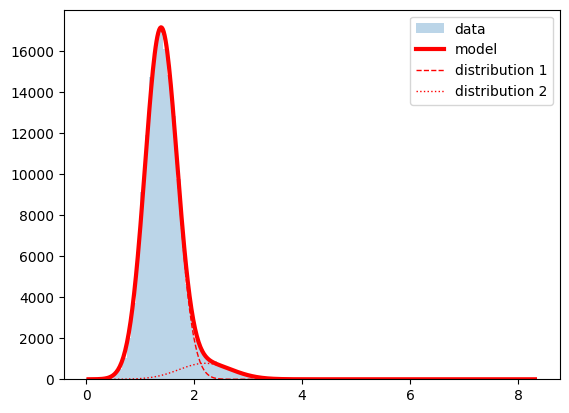

In [7]:
def plot_gaussians(cell_type):
    data= adata.X[: ,adata.var.index == cell_type]
    y,x,_=plt.hist(data, 100, alpha=.3, label='data')
    x=(x[1:]+x[:-1])/2 
    
    
    def gauss(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/2/sigma**2)
    
    def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    
    expected = (2, .2, 250, 3, .2, 125) ##expected = (1, .2, 250, 2, .2, 125)
    params, cov = curve_fit(bimodal, x, y, expected)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)
    
    plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
    
    plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
    plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
    
    plt.legend()
    print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
    plt.show() 

plot_gaussians("CD57") ##-- pretty example
##plot_gaussians(adata.var.index.to_numpy()[3]) ##-- pretty example
##plot_gaussians(adata.var.index.to_numpy()[1]) ##-- not working example
##plot_gaussians(adata.var.index.to_numpy()[5]) ##-- crashing example
##plot_gaussians(adata.var.index.to_numpy()[7]) ##-- crashing example

**?Possible fix?**
- Increase maxfev
  - I have no idea what this is but the curves look ugly after this (but at least no crashes)
- Play with the "exprected" parameter
  - Initialy was set to "expected = (1, .2, 250, 2, .2, 125)" the first and fourth influence the position where we look for the gaussians
  - Maybe calculate somehow the first and fourth value
- Actually try to understand the code
  - Some of the topics that the people on StackOverflow discuss sound like magic to me


**Notes** 

Find positive 
- 1. find intersect of two gaussians
- 2. false discovery rate

Find cells that are interesting (Paper) - > Confirm which are actualy those type (Histogram)
- Paper bar plot 
- Paper attachment - cell types

  
  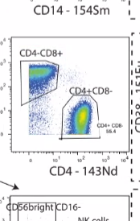

T lymphocyte
  - CD4 -
  - CD8 +
  - CD4 - <-> CD8 +

T effector
  - CD45RA +
  - CCR7 -

T effector memory
  - CD45RA -
  - CCR7 -

Treg cells
  - CD3, CD4, CD25 +
  - CD127 -

Monocytes
  - CD14 +
  - CD33 +

NK
  - CD3 -
  - CD16 +

Th2 non-TFH
  - ???

Central memory
  - CD45RA -
  - CCR7 - 
 
Lymphocytes
  - CD14 -  | -- Conditions FOR ALL lymphocytes
  - CD33 -  |
 
Plasmablasts
  - CD3 -
  - CD20 -
  - C27 +
  - CD38 +

T naive cells
  - CD45RA +
  - CCR7 - 
  
  


**Tasks** 

- figure out the thresholding
- count the cell types with each donor
  - threshold
  - sub set
  - count
  - 8 individuals
  - for each 30 barplots = smart visualization
- how do they count the frequencies = for now divide the cell counts by all cells

Other factors 
 - CNV virus
 - gender
 - dataset bias


scikitlear 
scipy

Gaussian clustering - Gaussian mixture model 

 

**Ploting thresholds**

In [8]:
expected_dictionary = {"CD57" : (2, .1, 250, 3, .1, 125),
                           "CD14" : (0.5, .1, 250, 1.7, .1, 125),
                           "CD4-1" : (2, .1, 250, 5, .1, 125),
#                           "CD4-2" : (0.5, .1, 250, 1.5, .1, 125),
                           "CD8": (0.5, .1, 250, 3.5, .1, 125),
                           "CD45RA" : (0.5, .1, 250, 1.8, .1, 125),
                           "CD3-1" : (0.7, .1, 250, 2.7, .1, 125),
                           "CD3-2" : (0.7, .1, 250, 3, .1, 125),
#                           "CD25" : (0.5, .1, 250, 1, .1, 125),
                           "CD127" : (0.6, .1, 250, 2, .1, 125),
#                           "CD33" : (2, .1, 250, 3, .1, 125),
                           "CD16" : (1, .1, 250, 3, .1, 125),
#                           "CD20" : (0, .1, 250, 0.4, .1, 125),
#                           "CD38-1" : (0, .1, 2500, 4, .1, 125),
#                           "CD38-2" : (0, .1, 2500, 4, .1, 125),
                           "CD161" : (0, .1, 250, 1.2, .1, 125),
                           "CD27" : (0.5, .1, 250, 3, .1, 125),
                           "CD28" : (1, .1, 250, 2.1, .1, 125),
#                           "CD185" : (2, .1, 250, 3, .1, 125), CXCR5
#                           "CD183" : (2, .1, 250, 3, .1, 125), CXCR3
#                           "CD196" : (2, .1, 250, 3, .1, 125),##CCR6
                      }
manual_histograms = ["CD4-2", "CD20", "CD38-1", "CD38-2", "CD185", "HLA-DR", "CD19", "CD28", "CD25", "CD196", "CD185"]
missing_data = ["CD33", "CD183"]

In [9]:
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / 2 / sigma**2)
    
def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1) + gauss(x, mu2, sigma2, A2)

def find_intersections(gauss1_params, gauss2_params, x_range):
    mu1, sigma1, A1 = gauss1_params
    mu2, sigma2, A2 = gauss2_params

    def difference(x):
        return gauss(x, mu1, sigma1, A1) - gauss(x, mu2, sigma2, A2)

    x_initial_guesses = np.linspace(x_range[0], x_range[1], 500)
    intersections = []

    for x0 in x_initial_guesses:
        root, info, ier, msg = fsolve(difference, x0, full_output=True)
        if ier == 1 and x_range[0] <= root <= x_range[1]:
            intersections.append(root[0])
    
    intersections = np.unique(intersections)
    return intersections

def draw_histograms(df, variables, n_rows, n_cols):
    intersection_dict = {}
    fig = plt.figure(figsize=(12,12))
    fig.suptitle('Approximation of the positivity threshold', fontsize=20, y=0.97)
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        data = adata.X[:, adata.var.index == var_name]
        if data.size == 0:
            print(var_name + " is empty\n")
            continue
        y, x, _ = ax.hist(data, bins=100, alpha=.3)
        x = (x[1:] + x[:-1]) / 2 
    
        expected = expected_dictionary[var_name]  # expected = (1, .2, 250, 2, .2, 125)
        try:
            params, cov = curve_fit(bimodal, x, y, expected)
        except RuntimeError:
            print(var_name)
            continue
        sigma = np.sqrt(np.diag(cov))
        x_fit = np.linspace(x.min(), x.max(), 500)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis='y', labelsize=10)
        
        ax.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1.5, ls="--")
        ax.plot(x_fit, gauss(x_fit, *params[3:]), color='green', lw=1.5, ls="-.")
        
        intersections = find_intersections(params[:3], params[3:], (x.min(), x.max()))
        
        for x_int in intersections[0:1]:
            ax.axvline(x=x_int, color='blue', linestyle='--', lw=2)
        
        intersection_dict[var_name] = intersections
        
        ax.set_title(var_name)

    
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig(fname = 'threshold_updated_v_0.2.pdf',format = 'pdf', orientation = 'portrait')
    plt.show()
    return intersection_dict


PROTEIN FEEDBACK

Čo sa týka chýbajúcich proteínov: 
1. Pre CD3, CD4 a CD38 v projekte použili dve rôzne protilátky. Keď si dáte vypísať všetky názvy riadkov, tak uvidíte, že tam je napr. CD3-1 a CD3-2. To sa niekedy robí, aby sa znížilo nešpecifické viazanie protilátky. Pre obidve verzie by mali zhruba tie isté bunky byť pozitívne - spravte 2D histogram (alebo 2D density plot) CD3-1 vs CD3-2, aby sme si to vizuálne overili. Ako CD3 pozitívne môžeme potom brať tie, ktoré sú pozitívne pre obe verzie protilátky. Podobne pre CD4 a CD38.
2. CD85j v dátach chýba, je tam len CD85g - subset buniek, pre ktorý potrebujeme CD85j, budeme musieť vyškrtnúť z analýzy
3. CCR7 chýba tiež, avšak keby sme vyškrtli všetky subsety s CCR7, tak nám ich zostane pomerne málo. Namiesto CCR7 sa dá pomerne dobre použiť CD27 alebo CD28. Nie je to dokonalé, ale musíme pracovať s tým, čo máme. Spravte prosím obidve verzie (teda jednu takú, kde miesto CCR7 používame CD27, jednu takú, kde namiesto CCR7 používame CD28).
4. Vo Vašom zozname ešte asi chýbajú nejaké proteíny, napr. CXCR5 alebo CCR6 (tieto majú aj svoje označenia začínajúce CD, vygooglite si na wikipedii). Pozrite si znova Fig. 3a v tom Nature Medicine článku, aby sme vedeli čím viac z tých subsetov kvantifikovať.

Skúste prosím následne spraviť barplot s frekvenciami všetkých relevantných subsetov pre každého donora zvlášť.

Ak budete mať otázky, píšte mi možno na whatsapp, 0940641163. Na mejly mi tieto dni trvá dlhšie odpovedať a nechcem, aby ste sa zdržiavali kvôli mne. 

Martin

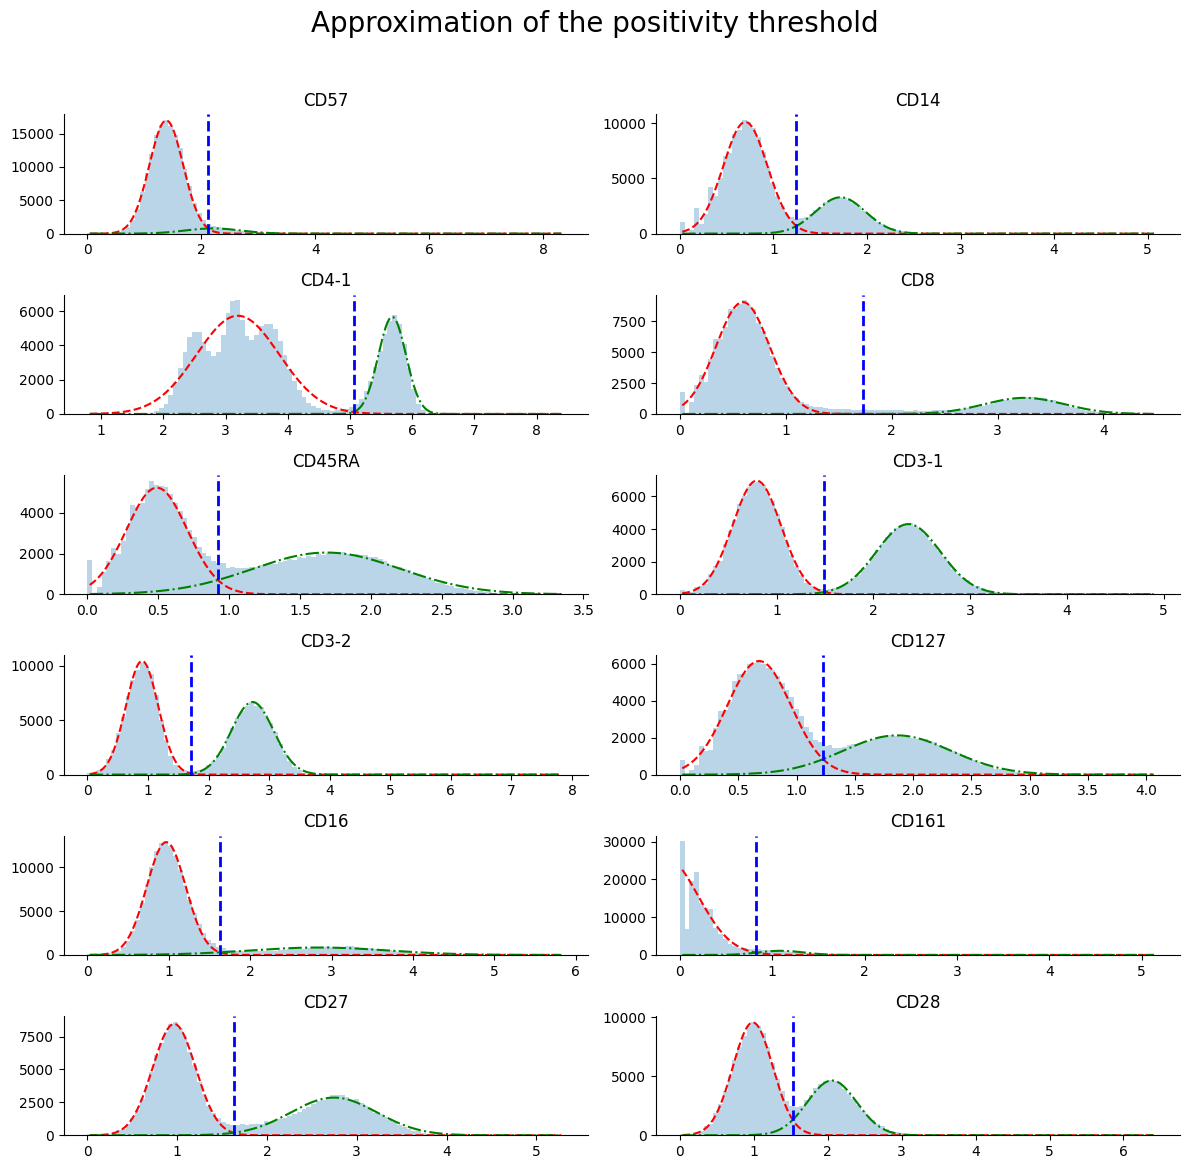

In [10]:
intersection = draw_histograms(adata, expected_dictionary.keys(), math.ceil(len(expected_dictionary)/2), 2)

**Creating cell marker definitions**

In [11]:
manual_intersection = {
    "HLA-DR": 1.7,
    "CD185": 0.6, 
    "CD38-2": 2.1,
    "CD38-1": 2.6,
    "CD20": 0.8,
    "CD4-2": 1.1,
    "CD19": 3,
    "CD28": 1.6,
    "CD25": 1.0,
    "CD196": 1.7,
    "CD185": 0.8
}

In [12]:
def draw_histograms_manual(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize = (12,12))
    fig.suptitle('Manual positivity threshold when approximation is not possible', fontsize=20, y=0.97)
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        data = adata.X[: ,adata.var.index == var_name]
        y,x,_ = ax.hist(data, bins = 100, alpha = .3)
        
        expected = manual_intersection[var_name]
        ax.axvline(x=expected, color='blue', linestyle='--', lw=2)
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis='y', labelsize=10)
        ax.set_title(var_name)

    fig.subplots_adjust(top=0.9)  
    
    fig.tight_layout(rect=[0, 0, 1, 0.95])   
    #plt.savefig(fname = 'threshold_updated_manual_v_0.1.png',format = 'png', orientation = 'portrait')
    plt.show()


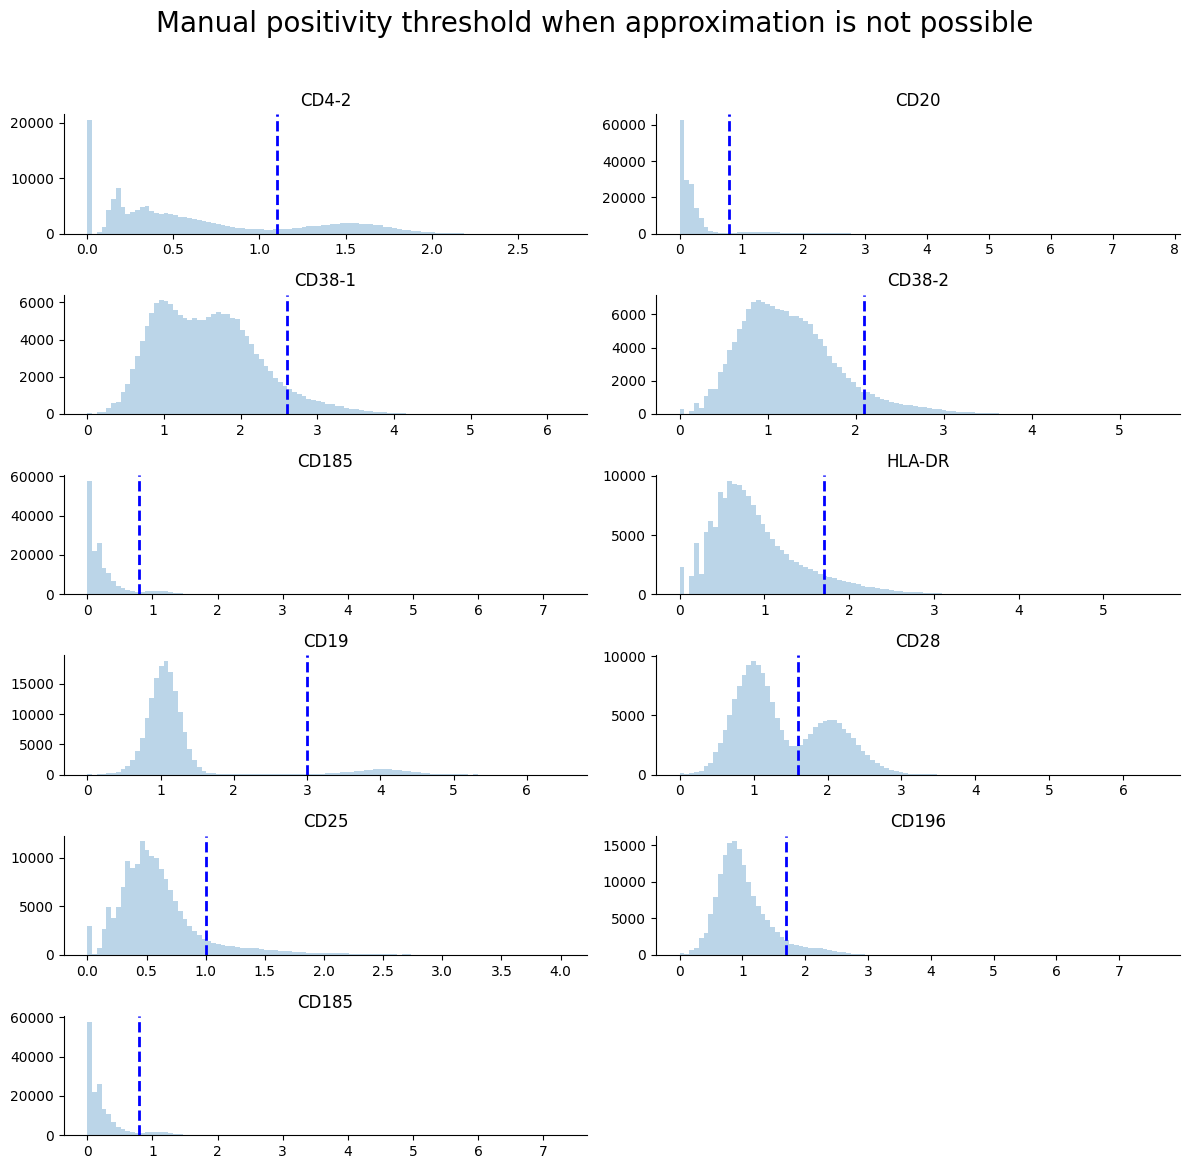

In [13]:
draw_histograms_manual(adata, manual_histograms, math.ceil(len(manual_histograms)/2), 2)

In [14]:
cell_type_dict = {
    "T": ["CD3-1 +", "CD3-2 +", "CD14 -"],
    "Effector": ["CD45RA +", "CCR7 -"],
    "Treg_cells": ["CD3-1 +", "CD3-2 +","CD4-1 +", "CD4-2 +","CD25 +","CD127 +"],
    "Monocytes": ["CD14 +","CD33 +"],
    "NK": ["CD3-1 -", "CD3-2 -","CD16 +"],
    "Central_memory": ["CD45RA -", "CCR7 +"],
    "Effector_memory": ["CD45RA -", "CCR7 -"],
    "Lymphocytes": ["CD14 -","CD33 -"],
    "Plasmablast": ["CD3-1 -", "CD3-2 -","CD20 -","CD27 +","CD38-1 +", "CD38-2 -"],
    "Naive": ["CD45RA +", "CCR7 +"],
    "B": ["CD20 +", "CD19 +"]   
}

In [15]:
CELLS = [
    "CD57 + CD8 + T",
    "Effector CD8 + T",
    "CD28 - CD8 + T",
    "Effector_memory CD8 + T",
    "Treg_cells",
    "Effector_memory CD4-1 + CD4-2 + T",
#    "Monocytes",
    "NK",
    "CD57 + NK",
    "Central_memory CD4-1 + CD4-2 + T",
    "HLA-DR - CD38-1 + CD38-2 + CD4-1 + CD4-2 + T",
    "T",
#    "Lymphocytes",
    "CD161 + NK",
    "CD8 + T",
    "Plasmablast",
    "Naive CD4-1 + CD4-2 + T",
    "B",
    "CD27 + CD8 + T",
    "CD161 - CD45RA + CD4-1 + CD4-2 + Treg_cells",
    "CD185 + CD4-1 + CD4-2 + T",
    "Naive CD8 + T"

#    "CD94 + NK",
#    "CXCR5 + CD8 + T",
#    "Th17 CXCR5–CD4+ T",
#    "Th1 TFH CD4 + T", 
#    "CXCR3–CCR6+CXCR5+CD8+ T",
#    "Th1 non-TFH CD4 + T",
#    "Th2 TFH CD4+ T",
#    "CXCR3 - CCR6 - CXCR5 + CD8 + T",
#    "Th2 non-TFH CD4 + T",
#    "PD1 + CD8 + T",   
]

**Counting cells with markers**

In [16]:
def cell_into_markers(cells):
    markers = {}
    for cell in cells:
        res = ""
        args = cell.split()
        for arg in args:
            if arg in cell_type_dict:
                res += " ".join(cell_type_dict[arg]) + " "
            else:
                res += arg
                if arg != args[-1]:
                    res += " "
        markers[cell] = res
    return markers


In [17]:
markers = cell_into_markers(CELLS)
for cell, marker in markers.items():
    total_width = 79
    cell_len = len(cell)
    buffer_size = total_width - cell_len
    
    left_buffer_size = buffer_size // 2
    right_buffer_size = buffer_size - left_buffer_size
    
    print("-" * left_buffer_size + cell + "-" * right_buffer_size)
    print(marker, "\n")


--------------------------------CD57 + CD8 + T---------------------------------
CD57 + CD8 + CD3-1 + CD3-2 + CD14 -  

-------------------------------Effector CD8 + T--------------------------------
CD45RA + CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  

--------------------------------CD28 - CD8 + T---------------------------------
CD28 - CD8 + CD3-1 + CD3-2 + CD14 -  

----------------------------Effector_memory CD8 + T----------------------------
CD45RA - CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  

----------------------------------Treg_cells-----------------------------------
CD3-1 + CD3-2 + CD4-1 + CD4-2 + CD25 + CD127 +  

-----------------------Effector_memory CD4-1 + CD4-2 + T-----------------------
CD45RA - CCR7 - CD4-1 + CD4-2 + CD3-1 + CD3-2 + CD14 -  

--------------------------------------NK---------------------------------------
CD3-1 - CD3-2 - CD16 +  

-----------------------------------CD57 + NK-----------------------------------
CD57 + CD3-1 - CD3-2 - CD16 +  

-------------------

In [18]:
def count_rows_with_multiple_conditions(adata, conditions, CCR7_replacement = "CCR7"):
    mask = np.ones(adata.shape[0], dtype=bool)
    args = conditions.split()
    
    for i in range(len(args)):
        column_name = args[i]
        
        if column_name in ["+", "-"]:
            continue
        if i == len(args) - 1:
            break
        if column_name == "CCR7" and CCR7_replacement != "CCR7":
            column_name = CCR7_replacement
            
        if column_name not in adata.var_names:
            print("MARKER NOT FOUND:", column_name)
            raise ValueError(f"Column '{column_name}' not found in adata.var_names")

        operator = args[i + 1]
        column_index = adata.var_names.get_loc(column_name)
        try:
            value = intersection[column_name][0]
            if column_name == "CD25":
                value = intersection[column_name][1]
            
        except KeyError:
            value = manual_intersection[column_name]

        column_data = adata.X[:, column_index]
        

        if operator == "+":
            mask &= (column_data > value)
        elif operator == "-":
            mask &= (column_data < value)
        

    
    count = np.sum(mask)
    
    return count

In [19]:
def print_counts(markers, adata):
    for cell, marker in markers.items():
        try:
            res = count_rows_with_multiple_conditions(adata, marker, "CD27")
            print("Success at cell type:", cell, "\nWith markers:", marker, "\nCount:", res)  
        except:
            print("Failed at cell type:", cell, "\nWith markers:", marker)
        print("\n")
print_counts(markers, adata)

Success at cell type: CD57 + CD8 + T 
With markers: CD57 + CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 3025


Success at cell type: Effector CD8 + T 
With markers: CD45RA + CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 5827


Success at cell type: CD28 - CD8 + T 
With markers: CD28 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 10952


Success at cell type: Effector_memory CD8 + T 
With markers: CD45RA - CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 2176


Success at cell type: Treg_cells 
With markers: CD3-1 + CD3-2 + CD4-1 + CD4-2 + CD25 + CD127 +  
Count: 9640


Success at cell type: Effector_memory CD4-1 + CD4-2 + T 
With markers: CD45RA - CCR7 - CD4-1 + CD4-2 + CD3-1 + CD3-2 + CD14 -  
Count: 3408


Success at cell type: NK 
With markers: CD3-1 - CD3-2 - CD16 +  
Count: 24966


Success at cell type: CD57 + NK 
With markers: CD57 + CD3-1 - CD3-2 - CD16 +  
Count: 3462


Success at cell type: Central_memory CD4-1 + CD4-2 + T 
With markers: CD45RA - CCR7 + CD4-1 + CD4-2 + CD3-1 + CD3-2 + CD14 -  
C

In [20]:
print_counts(markers ,full_data['ADT'][full_data.obs.donor == 'P1'])

Success at cell type: CD57 + CD8 + T 
With markers: CD57 + CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 224


Success at cell type: Effector CD8 + T 
With markers: CD45RA + CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 916


Success at cell type: CD28 - CD8 + T 
With markers: CD28 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 1345


Success at cell type: Effector_memory CD8 + T 
With markers: CD45RA - CCR7 - CD8 + CD3-1 + CD3-2 + CD14 -  
Count: 349


Success at cell type: Treg_cells 
With markers: CD3-1 + CD3-2 + CD4-1 + CD4-2 + CD25 + CD127 +  
Count: 1455


Success at cell type: Effector_memory CD4-1 + CD4-2 + T 
With markers: CD45RA - CCR7 - CD4-1 + CD4-2 + CD3-1 + CD3-2 + CD14 -  
Count: 572


Success at cell type: NK 
With markers: CD3-1 - CD3-2 - CD16 +  
Count: 2314


Success at cell type: CD57 + NK 
With markers: CD57 + CD3-1 - CD3-2 - CD16 +  
Count: 124


Success at cell type: Central_memory CD4-1 + CD4-2 + T 
With markers: CD45RA - CCR7 + CD4-1 + CD4-2 + CD3-1 + CD3-2 + CD14 -  
Count: 2

**Cell frequencies in donors histograms**

In [21]:
donors = sorted(list({x for x in full_data.obs.donor}))

In [22]:
def get_counts(markers, adata):
    counts_dict = {}
    for cell, marker in markers.items():
        try:
            count = count_rows_with_multiple_conditions(adata, marker, "CD27")
            counts_dict[cell] = count
        except:
            print("Failed at cell type:", cell, "\nWith markers:", marker, "\n")
    return counts_dict
        
def plot_donor_cells_histogram(donors, n_rows, n_cols):
    fig = plt.figure(figsize = (12,30))
    max_y = 0
    for i, donor in enumerate(donors):
        print("----", donor, "-----")
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        counts_dict = get_counts(markers, adata[full_data.obs.donor == donor])
        total_donor_count = adata[full_data.obs.donor == donor].n_obs
        
        ax.bar(counts_dict.keys(), [x / total_donor_count for x in counts_dict.values()], color='g')
        ax.set_title(donor)

        ax.set_xticks(range(len(counts_dict)))
        ax.set_xticklabels(counts_dict.keys(), rotation=90, ha='right')

        ax.set_ylim(0, 1)

        
    plt.tight_layout(pad=6.0)
    plt.show()

---- P1 -----
---- P2 -----
---- P3 -----
---- P4 -----
---- P5 -----
---- P6 -----
---- P7 -----
---- P8 -----


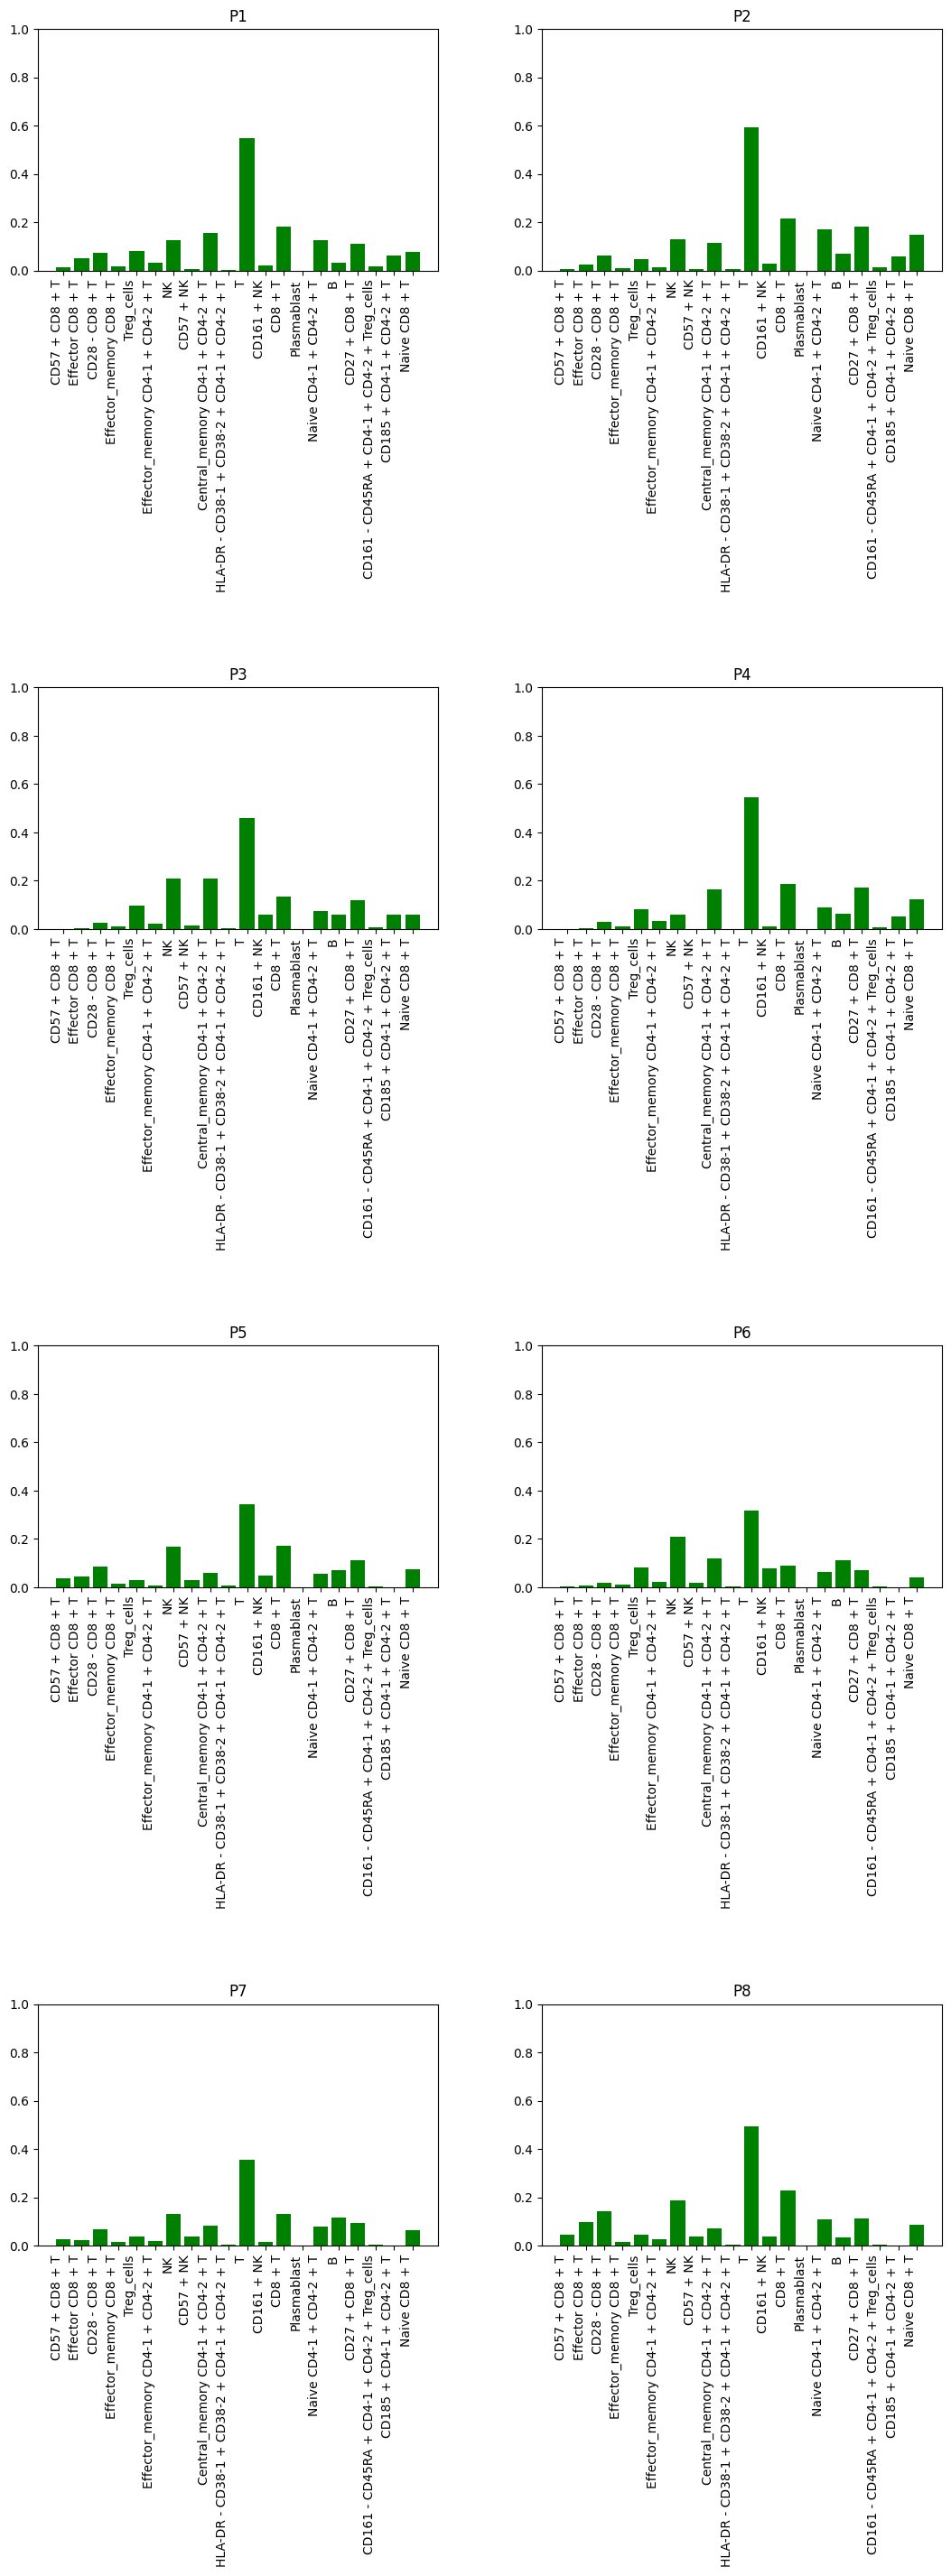

In [23]:
plot_donor_cells_histogram(donors, 4, 2)

In [24]:
def return_rows_with_multiple_conditions(adata, conditions, donor, CCR7_replacement = "CCR7"):
    donor_subset = adata[full_data.obs.donor == donor]
    mask = np.ones(donor_subset.shape[0], dtype=bool)
    args = conditions.split()

    for i in range(len(args)):
        column_name = args[i]
        
        if column_name in ["+", "-"]:
            continue
        if i == len(args) - 1:
            break
        if column_name == "CCR7" and CCR7_replacement != "CCR7":
            column_name = CCR7_replacement
            
        if column_name not in adata.var_names:
            print("MARKER NOT FOUND:", column_name)
            raise ValueError(f"Column '{column_name}' not found in adata.var_names")

        operator = args[i + 1]
        column_index = adata.var_names.get_loc(column_name)
        try:
            value = intersection[column_name][0]
            if column_name == "CD25":
                value = intersection[column_name][1]
            
        except KeyError:
            value = manual_intersection[column_name]

        column_data = donor_subset.X[:, column_index]

        if operator == "+":
            mask &= (column_data > value)
        elif operator == "-":
            mask &= (column_data < value)
    cell_donor_subset = donor_subset[mask]

        
    return cell_donor_subset

**Loading metadata of donors**

In [25]:
metadata_df = pd.read_excel("mmc3.xlsx")
metadata_df.set_index("Donor", inplace=True)

**Creating swarmplots for donor frequencies in cells**

In [26]:
def swarm_plot():
    counts_per_donor = {donor: {} for donor in donors}
    
    for donor in donors:
        counts_dict = get_counts(markers, adata[full_data.obs.donor == donor])
        total_donor_count = adata[full_data.obs.donor == donor].n_obs
        
        for cell_type, count in counts_dict.items():
            counts_per_donor[donor][cell_type] = count / total_donor_count

    df = pd.DataFrame.from_dict(counts_per_donor, orient='index')
    df_melted = df.reset_index().melt(id_vars='index', var_name='Cell_Type', value_name='Count')
    df_melted.rename(columns={'index': 'Donor'}, inplace=True)

    SIZE_DEFAULT = 14
    SIZE_LARGE = 16

    plt.rc("font", size=SIZE_DEFAULT)
    plt.rc("axes", titlesize=SIZE_LARGE)
    plt.rc("axes", labelsize=SIZE_LARGE)  
    plt.rc("xtick", labelsize=SIZE_DEFAULT - 5)  
    plt.rc("ytick", labelsize=SIZE_DEFAULT)  
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.swarmplot(data=df_melted, x='Cell_Type', y='Count', hue='Donor', palette='Set2')
    sns.despine(top = True, right = True, left = True)
    plt.title('Swarm Plot of Immune Cell Counts per Donor', fontsize = 'large')
    plt.ylabel('Count freqency')
    plt.xlabel('Cell type')
    plt.legend(title='Donor')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    #plt.savefig(fname = 'swarmplot_updated',format = 'pdf', orientation = 'portrait')
    plt.show()
    return df_melted


/home/hruzko/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/hruzko/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


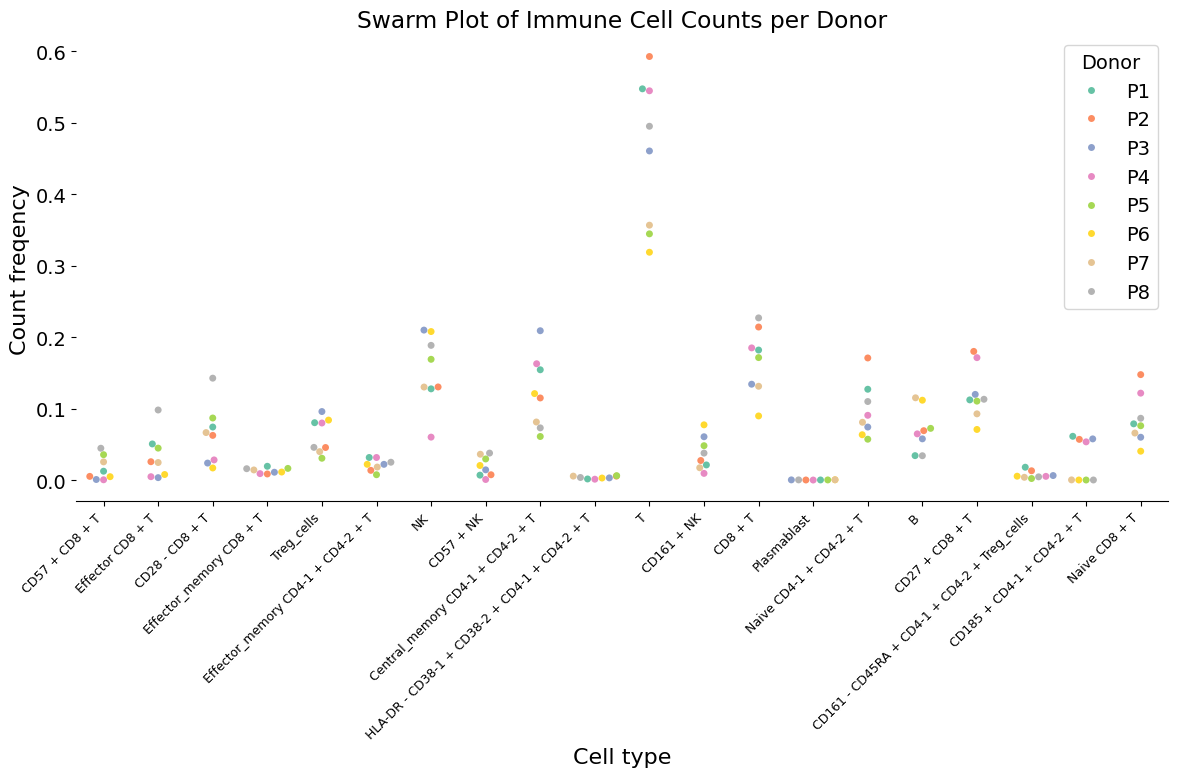

In [27]:
counts_long_df = swarm_plot()

In [28]:
counts_long_df["CMV_positive"] = counts_long_df["Donor"].apply(lambda x: True if metadata_df.loc[x].CMV == "positive" else False)
counts_long_df["Gender"] = counts_long_df["Donor"].apply(lambda x: "Male"  if metadata_df.loc[x].Gender == "M" else "Female")
counts_long_df["Treatment"] = counts_long_df["Donor"].apply(lambda x: metadata_df.loc[x].Treatment)

In [29]:
counts_long_df

,Donor,Cell_Type,Count,CMV_positive,Gender,Treatment
0,P1,CD57 + CD8 + T,0.012352,True,Male,3
1,P2,CD57 + CD8 + T,0.005115,True,Male,3
2,P3,CD57 + CD8 + T,0.000750,False,Male,1
3,P4,CD57 + CD8 + T,0.000351,True,Male,3
4,P5,CD57 + CD8 + T,0.035487,True,Male,1
...,...,...,...,...,...,...
155,P4,Naive CD8 + T,0.121592,True,Male,3
156,P5,Naive CD8 + T,0.075971,True,Male,1
157,P6,Naive CD8 + T,0.040353,False,Female,1
158,P7,Naive CD8 + T,0.065749,False,Female,1


**Conducting ANOVA to see if any of the variables influence the frequencies**

In [30]:
counts_long_df[counts_long_df['Cell_Type'] == 'CD57 + CD8 + T'].iloc[:, [2,5]]
##z tohoto potom spravis funkciu ktora dostane ktory parameter berieme ako premenny a spravi ANOVU 
##pre vsetky bunky
def anova_get_p_value(data):
    cell_types = set(counts_long_df.iloc[: , 1])
    anova_var = {'Gender', 'Treatment', 'CMV_positive'}
    anova_to_p_vals_dict = {}
    p_vals = {}
    
    for column in anova_var:
        print("Now running anova for:", column, "\n")
        
        for cell_type in cell_types:
            curr_data = data[data['Cell_Type'] == cell_type]
            formula = f'Count ~ C({column})'
            model = ols(formula, data=curr_data).fit()
            anova_results = sm.stats.anova_lm(model, typ=2)

            p_value = anova_results["PR(>F)"][f"C({column})"]
            if p_value <= 0.05:
                print("Null hypothesis rejected with cell type:", cell_type, "and p value:", str(round(p_value, 5)))
            p_vals[cell_type] = p_value
            
        print("\nFinished running anova for:", column, "\n")
        
        anova_to_p_vals_dict[column] = p_vals
        p_vals = {}
    return anova_to_p_vals_dict
    



In [31]:
anova_vals = anova_get_p_value(counts_long_df)

Now running anova for: CMV_positive 

Null hypothesis rejected with cell type: Plasmablast and p value: 0.01188
Null hypothesis rejected with cell type: CD8 + T and p value: 0.00444

Finished running anova for: CMV_positive 

Now running anova for: Treatment 

Null hypothesis rejected with cell type: Naive CD8 + T and p value: 0.03135
Null hypothesis rejected with cell type: CD57 + NK and p value: 0.01098
Null hypothesis rejected with cell type: CD27 + CD8 + T and p value: 0.03467
Null hypothesis rejected with cell type: CD161 - CD45RA + CD4-1 + CD4-2 + Treg_cells and p value: 0.0382
Null hypothesis rejected with cell type: Plasmablast and p value: 0.02698
Null hypothesis rejected with cell type: NK and p value: 0.02709
Null hypothesis rejected with cell type: CD185 + CD4-1 + CD4-2 + T and p value: 0.02537
Null hypothesis rejected with cell type: Naive CD4-1 + CD4-2 + T and p value: 0.046
Null hypothesis rejected with cell type: T and p value: 0.01297

Finished running anova for: Treat

In [32]:
@contextmanager
def redirect_stdout(to):
    original_stdout = sys.stdout
    sys.stdout = to
    try:
        yield
    finally:
        sys.stdout = original_stdout


#with open('anova_res.txt', 'w') as f:
#    with redirect_stdout(f):
#        anova_vals = anova_get_p_value(counts_long_df)



In [33]:
def get_cell_subset_mask(conditions, CCR7_replacement = "CCR7", exclude_bias = False):
    mask = np.ones(adata.shape[0], dtype=bool)
    
    if exclude_bias:
        patient_ids = list(full_data.obs.donor)
        patient_ids_array = np.array(patient_ids)

        exclude_patients = {'P1', 'P2', 'P4'}
        mask = ~np.isin(patient_ids_array, list(exclude_patients))
    
    args = conditions.split()

    for i in range(len(args)):
        column_name = args[i]
        
        if column_name in ["+", "-"]:
            continue
        if i == len(args) - 1:
            break
        if column_name == "CCR7" and CCR7_replacement != "CCR7":
            column_name = CCR7_replacement
            
        if column_name not in adata.var_names:
            print("MARKER NOT FOUND:", column_name)
            raise ValueError(f"Column '{column_name}' not found in adata.var_names")

        operator = args[i + 1]
        column_index = adata.var_names.get_loc(column_name)
        try:
            value = intersection[column_name][0]
            if column_name == "CD25":
                value = intersection[column_name][1]
            
        except KeyError:
            value = manual_intersection[column_name]

        column_data = adata.X[:, column_index]

        if operator == "+":
            mask &= (column_data > value)
        elif operator == "-":
            mask &= (column_data < value)
            

    return mask

In [34]:
adata_df = adata.to_df()

In [35]:
adata_metadata_df = pd.concat([full_data.obs.donor, adata_df], axis=1)

In [36]:
adata_metadata_df["CMV_positive"] = adata_metadata_df["donor"].apply(lambda x: True if metadata_df.loc[x].CMV == "positive" else False)
adata_metadata_df["gender"] = adata_metadata_df["donor"].apply(lambda x: "Male"  if metadata_df.loc[x].Gender == "M" else "Female")
adata_metadata_df["treatment"] = adata_metadata_df["donor"].apply(lambda x: metadata_df.loc[x].Treatment)

In [37]:
adata_metadata_df

,donor,CD39,Rat-IgG1-1,CD107a,CD62P,TCR-2,CD30,CD31,CD34,CD35,...,CD163,CD138-1,CD164,CD138-2,CD144,CD202b,CD11c,CMV_positive,gender,treatment
L1_AAACCCAAGAAACTCA,P2,1.959164,0.869142,1.485233,2.646886,0.314297,0.244492,3.150274,0.604817,4.254588,...,0.788555,0.379546,0.379546,0.604817,0.553076,1.046084,1.725657,True,Male,3
L1_AAACCCAAGACATACA,P1,0.432228,1.014228,0.795950,2.294687,1.722023,0.340404,1.938390,0.516326,2.163873,...,0.733028,0.432228,0.126784,0.340404,0.665880,0.855146,1.379717,True,Male,3
L1_AAACCCACAACTGGTT,P4,0.613818,1.303906,0.756104,2.658653,0.880643,0.820311,2.743948,0.447873,2.248626,...,0.613818,0.534284,0.132120,1.042460,0.687489,0.756104,1.042460,True,Male,3
L1_AAACCCACACGTACTA,P3,0.567986,0.567986,0.651101,2.571268,0.927990,0.000000,2.320082,0.727835,2.258084,...,0.927990,0.727835,0.000000,0.986697,0.377632,0.927990,1.094686,False,Male,1
L1_AAACCCACAGCATACT,P4,0.421515,0.837539,1.042022,2.777125,0.837539,0.421515,3.142011,0.580205,2.357822,...,0.123162,0.421515,0.123162,0.944998,0.504004,0.994686,0.944998,True,Male,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,P5,0.180454,0.333269,1.155425,2.539072,1.472917,0.180454,2.423349,0.782333,1.748551,...,0.333269,0.582799,0.465797,0.333269,0.687535,1.091122,0.868918,True,Male,1
E2L8_TTTGTTGGTGTGCCTG,P5,1.759616,0.683942,1.554002,3.263118,0.732292,0.093643,2.968129,0.463108,3.950261,...,0.822498,0.523054,0.732292,0.633136,0.399338,0.463108,2.285955,True,Male,1
E2L8_TTTGTTGGTTAGTTCG,P8,1.506854,0.549146,1.065611,2.518959,0.460849,0.460849,1.858658,0.549146,4.832687,...,0.549146,0.460849,1.473884,0.549146,0.256740,0.256740,1.161687,True,Male,1
E2L8_TTTGTTGGTTGGCTAT,P5,1.635378,0.325206,1.195708,3.352521,0.570207,0.253275,2.911824,0.852331,2.324698,...,0.570207,0.514351,0.175765,0.810498,0.455191,0.514351,2.104857,True,Male,1


In [38]:
print(list(markers.keys())[0])

CD57 + CD8 + T


Po chvilke boxplot rozmyslania som dosiel k tomu ze by to asi aj islo ale je zistil som ze nerozumiem co vlstne mam merat v tych box plotoch.

In [39]:
metadata_df

,SubjectID,Gender,CMV,Treatment,CD8+ T cell CMV response
Donor,,,,,
P1,123520013,M,positive,3,0.233536
P2,123520024,M,positive,3,1.031558
P3,123520225,M,negative,1,-0.008088
P4,123520294,M,positive,3,0.229200
P5,123520339,M,positive,1,0.323024
P6,123520347,F,negative,1,-0.000263
P7,134520164,F,negative,1,0.062004
P8,158520052,M,positive,1,2.350690


In [40]:
sadata = full_data["SCT"]

In [41]:
def get_expression_profiles():
    average_per_cell_type = {cell_type: {} for cell_type in markers.keys()}
    gene_names = sadata.var.index
    
    for cell, marker in markers.items():
        print("----" + cell + "----\n")
        curr_mask = get_cell_subset_mask(marker, CCR7_replacement="CD27", exclude_bias=True)
        curr_sadata = sadata[curr_mask]

        column_means = np.array(curr_sadata.X.mean(axis=0)).flatten()
        for colindex in range(curr_sadata.n_vars):
            gene_name = gene_names[colindex]
            average_per_cell_type[cell][gene_name] = column_means[colindex]
            
    df = pd.DataFrame.from_dict(average_per_cell_type, orient='index')

    return df

In [42]:
sadata.X[:, 20728].mean()

2.570957124798887e-05

In [43]:
sadata.var.index[1]

'AL669831.5'

In [44]:
expression_profiles = get_expression_profiles()
#expression_profiles.to_csv("expresion_profiles.csv", index=False)

----CD57 + CD8 + T----

----Effector CD8 + T----

----CD28 - CD8 + T----

----Effector_memory CD8 + T----

----Treg_cells----

----Effector_memory CD4-1 + CD4-2 + T----

----NK----

----CD57 + NK----

----Central_memory CD4-1 + CD4-2 + T----

----HLA-DR - CD38-1 + CD38-2 + CD4-1 + CD4-2 + T----

----T----

----CD161 + NK----

----CD8 + T----

----Plasmablast----

----Naive CD4-1 + CD4-2 + T----

----B----

----CD27 + CD8 + T----

----CD161 - CD45RA + CD4-1 + CD4-2 + Treg_cells----

----CD185 + CD4-1 + CD4-2 + T----

----Naive CD8 + T----



# Delete big variables that are unused In older code

In [45]:
import gc

del full_data
del adata
del sadata

#alebo

#%reset_selective -f "^adata$"
#%reset_selective -f "^sadata$"
#%reset_selective -f "^full_data$"

gc.collect()

43788

In [46]:
mean_old_young = pd.read_excel("graph_excel.xlsx", index_col = "Name")
mean_old_young = mean_old_young.iloc[ : , 1:3]
mean_old_young['Real val'] = mean_old_young['Real val'].apply(np.log)

In [47]:
mean_old_young

,Table len pixel,Real val
Name,,
CD57 + CD8 + T,406,0.947699
Effector CD8 + T,174,0.517032
CD28 - CD8 + T,157,0.476790
Effector_memory CD8 + T,145,0.447376
Treg_cells,99,0.325855
Effector_memory CD4-1 + CD4-2 + T,90,0.300249
NK,63,0.219245
CD57 + NK,59,0.206666
Central_memory CD4-1 + CD4-2 + T,54,0.190717


In [48]:
set(CELLS) == set(mean_old_young.index)

True

In [49]:
#expression_profiles["TLR4"]
#plt.bar(height = expression_profiles["TLR1"], x = expression_profiles["TLR1"].index)
#plt.xticks(rotation=45, ha='right')
expression_profiles

,AL627309.1,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,AL645608.8,HES4,ISG15,...,AC092718.2,AC087742.1,TMEM98,ANGPT4,CFAP61,AC016588.1,FAM83E,Z82244.2,AP001468.1,AP001469.2
CD57 + CD8 + T,0.000512,0.033230,0.010904,0.010242,0.158483,0.012634,0.005783,0.000256,0.015702,0.444358,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000256,0.0
Effector CD8 + T,0.001263,0.029201,0.010948,0.009947,0.166344,0.016778,0.004921,0.000000,0.013067,0.424005,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000158,0.0
CD28 - CD8 + T,0.001686,0.027612,0.011853,0.010726,0.157932,0.016030,0.003545,0.000086,0.012132,0.422540,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000086,0.0
Effector_memory CD8 + T,0.001626,0.030359,0.015954,0.011341,0.148518,0.014405,0.004536,0.000000,0.015724,0.491815,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Treg_cells,0.001263,0.024415,0.011040,0.009710,0.135798,0.009825,0.007319,0.000230,0.010923,0.420848,...,0.000115,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Effector_memory CD4-1 + CD4-2 + T,0.001679,0.024376,0.008928,0.013490,0.146276,0.010271,0.008396,0.000336,0.014131,0.467058,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
NK,0.001773,0.034732,0.015382,0.011902,0.171644,0.012974,0.002137,0.002908,0.278050,0.663896,...,0.000036,0.000036,0.0,0.0,0.000036,0.000000,0.000000,0.0,0.000036,0.0
CD57 + NK,0.001951,0.026067,0.011344,0.010747,0.146394,0.012264,0.003505,0.000867,0.064116,0.561025,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000217,0.0
Central_memory CD4-1 + CD4-2 + T,0.001079,0.027852,0.011994,0.009497,0.136422,0.011057,0.007397,0.000190,0.012565,0.409978,...,0.000063,0.000000,0.0,0.0,0.000000,0.000000,0.000063,0.0,0.000000,0.0
HLA-DR - CD38-1 + CD38-2 + CD4-1 + CD4-2 + T,0.001475,0.037983,0.019172,0.016223,0.178839,0.011798,0.004424,0.000000,0.035645,0.537285,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [50]:
correlation_results_pearson = {}
for gene in expression_profiles.columns:
    expression_values = expression_profiles[gene]
    frequency_ratios = mean_old_young['Real val']
    correlation, p_value = pearsonr(expression_values, frequency_ratios)
    correlation_results_pearson[gene] = correlation

correlation_df_pearson = pd.DataFrame.from_dict(correlation_results_pearson, orient='index', columns=['Correlation'])


/tmp/ipykernel_19958/3755412972.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(expression_values, frequency_ratios)


In [51]:
correlation_df_pearson

,Correlation
AL627309.1,-0.326460
AL669831.5,-0.019588
LINC00115,0.081988
FAM41C,0.137088
NOC2L,0.366524
...,...
AC016588.1,-0.042237
FAM83E,-0.133924
Z82244.2,NaN
AP001468.1,0.618789


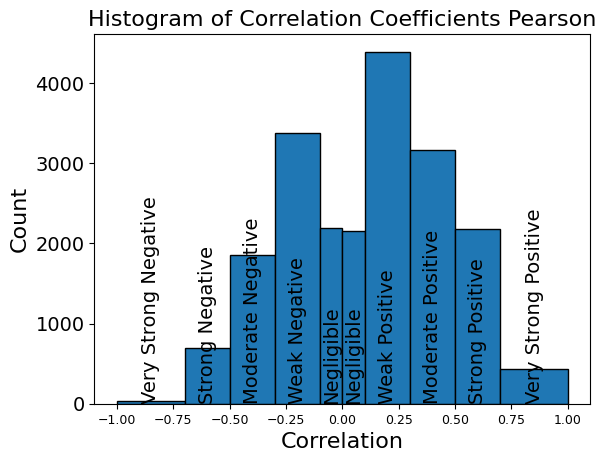

In [52]:
bins1 = [-1.0, -0.7, -0.5, -0.3, -0.1, 0.0, 0.1, 0.3, 0.5, 0.7, 1.0]
  
plt.hist(correlation_df_pearson["Correlation"], bins=bins1, edgecolor='black') 
bin_labels = [
    "Very Strong Negative", "Strong Negative", "Moderate Negative", "Weak Negative", "Negligible",
    "Negligible", "Weak Positive", "Moderate Positive", "Strong Positive", "Very Strong Positive"
]
bin_positions = [(bins1[i] + bins1[i+1]) / 2 for i in range(len(bins1)-1)]
for pos, label in zip(bin_positions, bin_labels):
    plt.text(pos, 0.5, label, rotation=90, ha='center', va='bottom')

plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of Correlation Coefficients Pearson')
plt.show()


In [53]:
correlation_results_spearman = {}
for gene in expression_profiles.columns:
    expression_values = expression_profiles[gene]
    frequency_ratios = mean_old_young['Real val']
    correlation, p_value = spearmanr(expression_values, frequency_ratios)
    correlation_results_spearman[gene] = correlation

correlation_df_spearman = pd.DataFrame.from_dict(correlation_results_spearman, orient='index', columns=['Correlation'])


/tmp/ipykernel_19958/3297126797.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = spearmanr(expression_values, frequency_ratios)


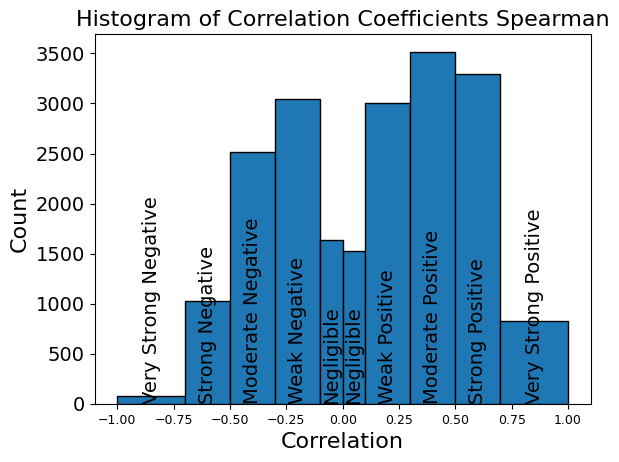

In [54]:
plt.hist(correlation_df_spearman["Correlation"], bins=bins1, edgecolor='black')


for pos, label in zip(bin_positions, bin_labels):
    plt.text(pos, 0.5, label, rotation=90, ha='center', va='bottom')

plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of Correlation Coefficients Spearman')
plt.show()

In [55]:
correlation_df_pearson_sorted = correlation_df_pearson.sort_values(by = 'Correlation', ascending = False)
correlation_df_spearman_sorted = correlation_df_spearman.sort_values(by = 'Correlation', ascending = False)

In [56]:
correlation_df_pearson_sorted.dropna(inplace=True)
correlation_df_spearman_sorted.dropna(inplace=True)
#correlation_df_spearman_sorted.to_csv("sorted_spearman_df_test")
#correlation_df_pearson_sorted.to_csv("sorted_pearson_df_test")
correlation_df_spearman_sorted

,Correlation
NCAPG2,0.923308
KLF3,0.905263
ORAI1,0.903759
RDX,0.899248
NDUFB10,0.899248
...,...
RBM26-AS1,-0.789474
AL355338.1,-0.816541
BEND5,-0.818045
PPIL3,-0.822556


In [57]:
def get_gsea(table, table_name, library_name, VERBOSE=False):
    results = gp.prerank(rnk=table, 
                         gene_sets=library_name, 
                         outdir='prerank_output_' + table_name + '_' + library_name, 
                         organism='Human', 
                         permutation_num=1000,
                         verbose=VERBOSE)

    return results

#res_p_GBP = get_gsea(correlation_df_pearson_sorted, 'correlation_df_pearson_sorted', 'GO_Biological_Process_2023')

#res_p_GCC = get_gsea(correlation_df_pearson_sorted, 'correlation_df_pearson_sorted', 'GO_Cellular_Component_2023')

#res_p_GMF = get_gsea(correlation_df_pearson_sorted, 'correlation_df_pearson_sorted', 'GO_Molecular_Function_2023')

#res_p_REA = get_gsea(correlation_df_pearson_sorted, 'correlation_df_pearson_sorted', 'Reactome_2022')

res_s_GBP = get_gsea(correlation_df_spearman_sorted, 'correlation_df_spearman_sorted', 'GO_Biological_Process_2023', VERBOSE = True)

#get_gsea(correlation_df_spearman_sorted, 'correlation_df_spearman_sorted', 'GO_Cellular_Component_2023')

#get_gsea(correlation_df_spearman_sorted, 'correlation_df_spearman_sorted', 'GO_Molecular_Function_2023')

#gp.get_library_name()


2025-02-10 14:48:42,242 [WARNING] Duplicated values found in preranked stats: 70.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-10 14:48:42,243 [INFO] Parsing data files for GSEA.............................
2025-02-10 14:48:42,245 [INFO] Enrichr library gene sets already downloaded in: /home/hruzko/.cache/gseapy, use local file
2025-02-10 14:48:42,412 [INFO] 3022 gene_sets have been filtered out when max_size=500 and min_size=15
2025-02-10 14:48:42,414 [INFO] 2385 gene_sets used for further statistical testing.....
2025-02-10 14:48:42,415 [INFO] Start to run GSEA...Might take a while..................
2025-02-10 14:50:51,894 [INFO] Start to generate gseapy reports, and produce figures...
2025-02-10 14:50:51,895 [INFO] Congratulations. GSEApy runs successfully................



In [58]:
df_res_s_GBP = res_s_GBP.res2d
df_res_s_GBP

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Cytoplasmic Translation (GO:0002181),-0.741827,-4.351314,0.0,0.0,0.0,75/91,12.68%,RPL21;RPS17;RPL10A;RPS10;RPS9;RPS5;RPS3A;RPL27...
1,prerank,Peptide Biosynthetic Process (GO:0043043),-0.562332,-3.479043,0.0,0.0,0.0,89/143,12.68%,GSPT2;RPL21;RPS17;RPL10A;RPS10;RPS9;RPS5;RPS3A...
2,prerank,Macromolecule Biosynthetic Process (GO:0009059),-0.49498,-3.079003,0.0,0.0,0.0,95/172,12.68%,GSPT2;EEF1B2;RPL21;EEF1G;RPS17;POLD2;RPL10A;RP...
3,prerank,Translation (GO:0006412),-0.423015,-2.829411,0.0,0.0,0.0,100/216,12.68%,GSPT2;MRPS27;EEF1B2;RPL21;MRPS25;EEF1G;RPS17;R...
4,prerank,Cellular Response To Lipopolysaccharide (GO:00...,0.574754,2.446116,0.0,0.0,0.0,72/108,27.66%,CDC73;HMGB2;GIT1;CASP1;TNIP2;PDCD1LG2;TNFRSF1B...
...,...,...,...,...,...,...,...,...,...,...
2380,prerank,Cardiac Muscle Cell Action Potential Involved ...,0.163205,0.519322,0.983503,0.991622,1.0,6/20,35.46%,KCNE5;RYR2;KCNE1;KCNE3;CACNA1D;KCNJ2
2381,prerank,Branching Morphogenesis Of An Epithelial Tube ...,0.154574,0.512418,0.986979,0.992428,1.0,10/24,44.91%,CTNNB1;RASIP1;PKD2;EPHA2;PAX8;SHH;FGF2;PAK1;GD...
2382,prerank,Chromosome Organization (GO:0051276),0.151458,0.51238,0.993758,0.991998,1.0,14/29,44.32%,RB1;TCF7L2;HHEX;NUF2;CDCA8;NAA10;AIFM1;NUP133;...
2383,prerank,Cell-Cell Junction Organization (GO:0045216),0.135666,0.509632,0.994193,0.992025,1.0,17/47,40.12%,MYADM;TGFB1;TLN1;F2R;LIM2;PRKCI;TLN2;CSK;SMAD3...


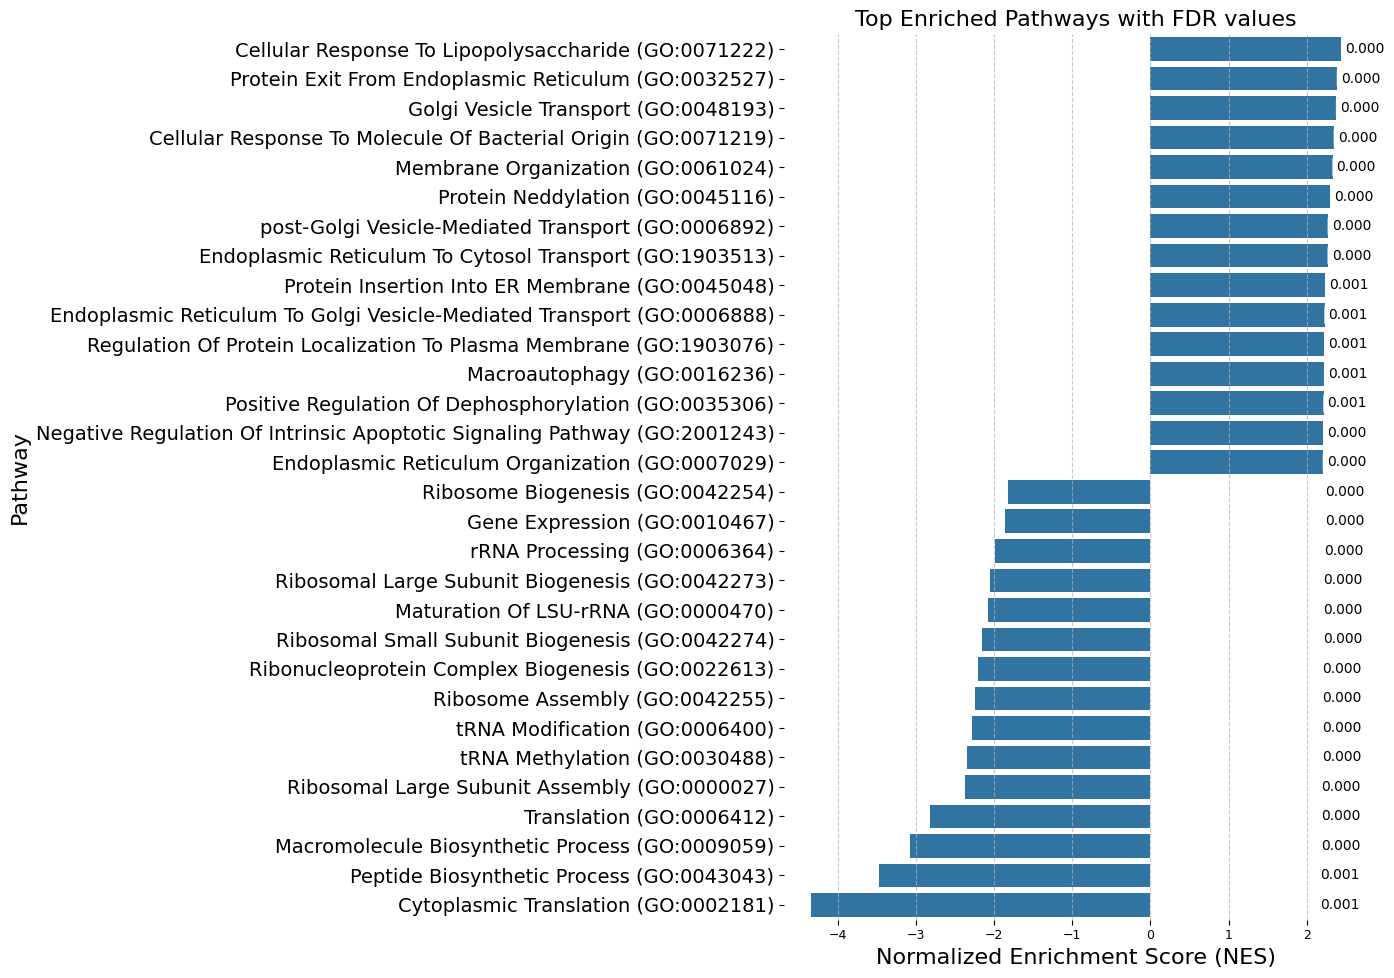

In [59]:
gsea_results = res_s_GBP.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val', 'Lead_genes', 'Tag %', 'Gene %']].sort_values('NES', ascending=False)

plt.figure(figsize=(14, 10))  
barplot = sns.barplot(x='NES', y='Term', data = pd.concat([gsea_results.head(15), gsea_results.tail(15)]))


for index, value in enumerate(gsea_results.head(30)['FDR q-val']):
    barplot.text(gsea_results.head(30)['NES'].iloc[index] + 0.05, index, f'{value:.3f}', color='black', ha="left", va="center", fontsize=10, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))


plt.xlabel('Normalized Enrichment Score (NES)')
plt.ylabel('Pathway')
plt.title('Top Enriched Pathways with FDR values')


sns.despine(left=True, bottom=True)  
plt.grid(axis='x', linestyle='--', alpha=0.7)
#barplot.set(xticks=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2.0, 2.25])
plt.tight_layout()  


plt.show()

/home/hruzko/miniconda3/envs/MAD_safe_version/lib/python3.10/site-packages/gseapy/plot.py:738: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


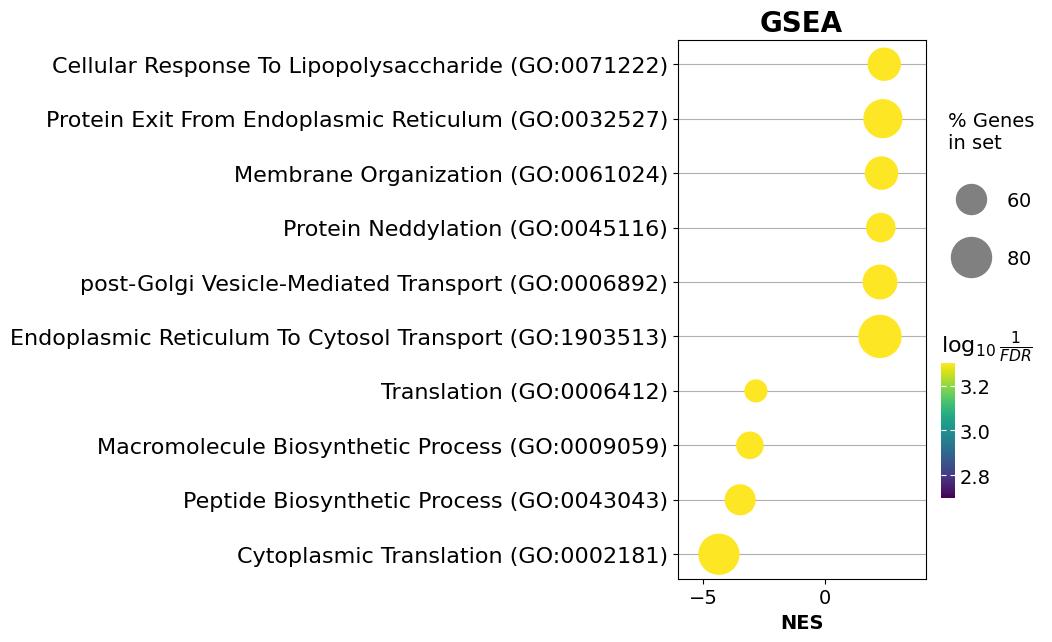

In [60]:
ax = gp.dotplot(res_s_GBP.res2d,
             column="FDR q-val",
             title='GSEA',
             cmap=plt.cm.viridis,
             size=6, 
             figsize=(4,7), cutoff=1, show_ring=False)

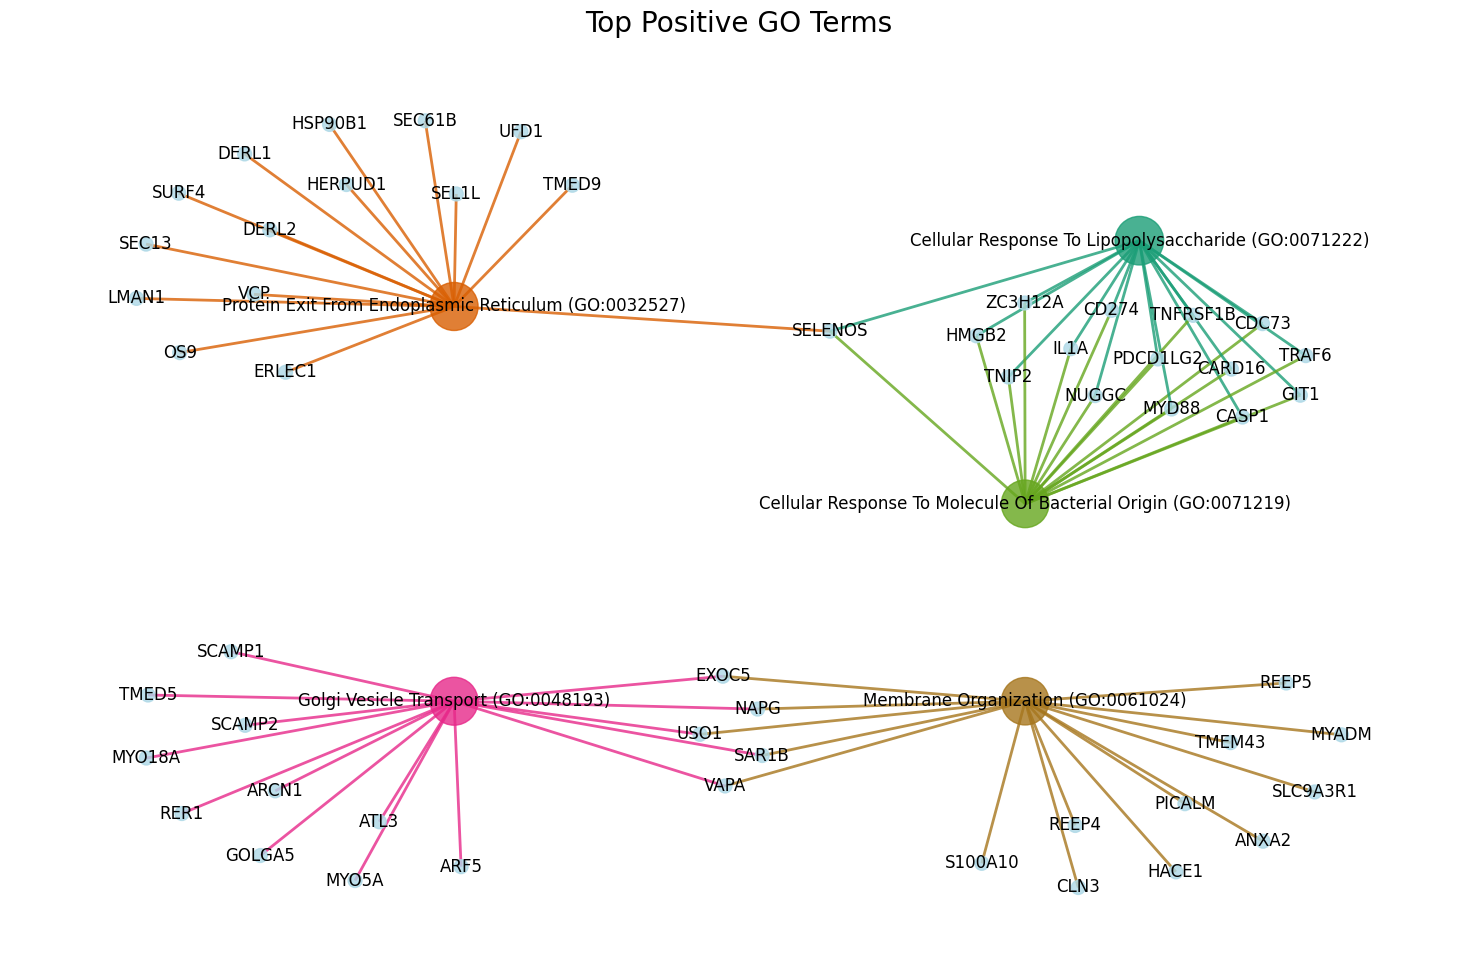

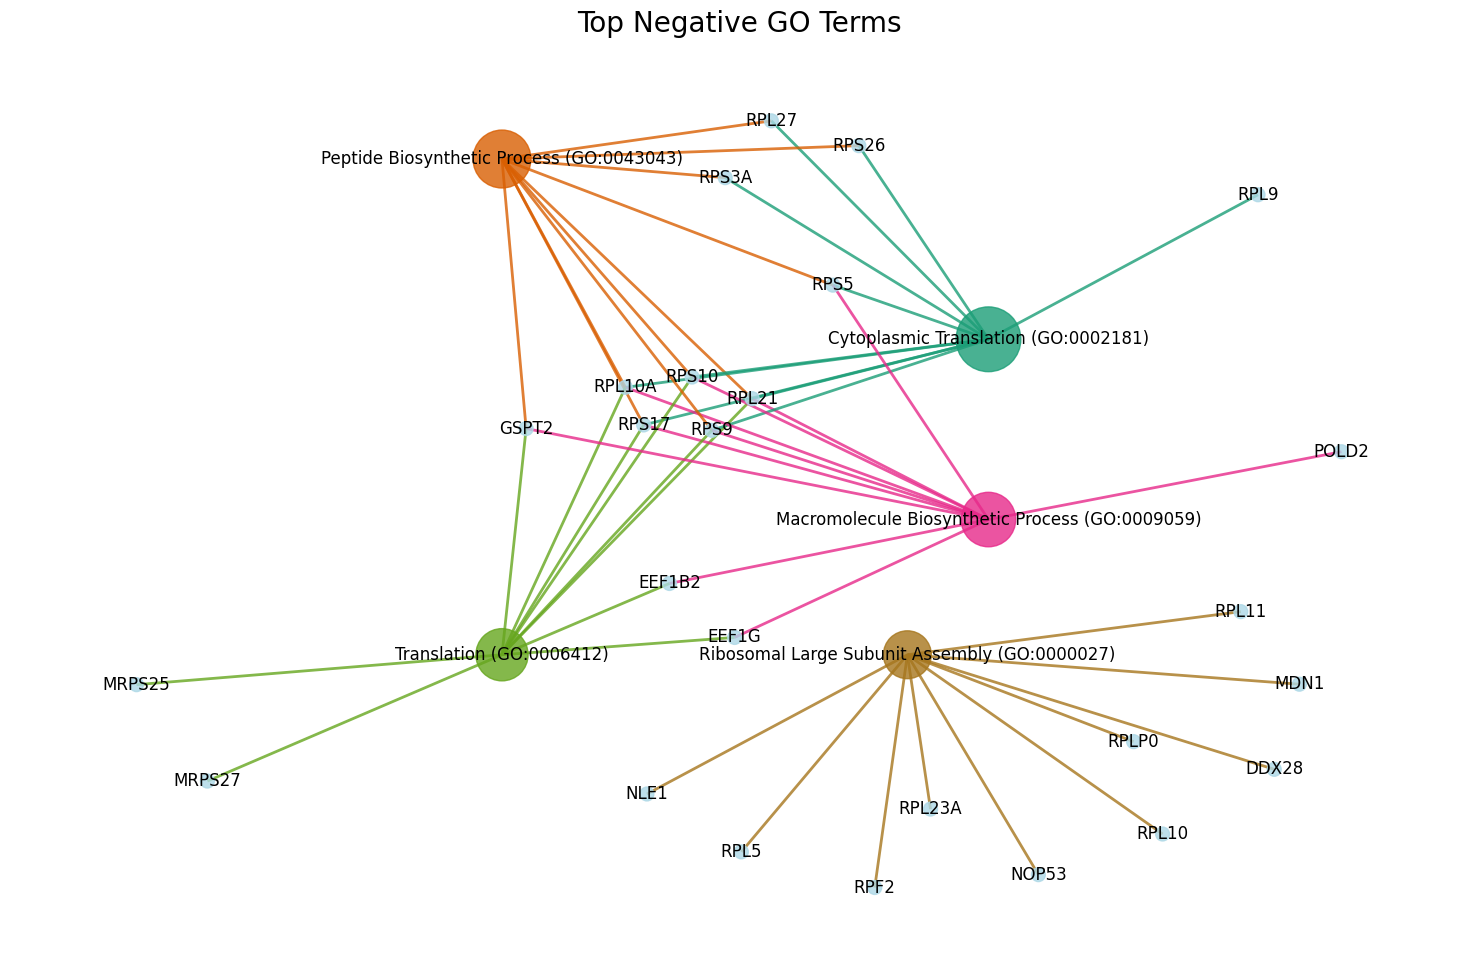

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text


gsea_results['NES'] = pd.to_numeric(gsea_results['NES'], errors='coerce')

gsea_results = gsea_results.dropna(subset=['NES'])

num_terms = 5  
top_pos_terms = gsea_results[gsea_results['NES'] > 0].nlargest(num_terms, 'NES')
top_neg_terms = gsea_results[gsea_results['NES'] < 0].nsmallest(num_terms, 'NES')


def create_edge_list(top_terms, top_genes_per_term=5):
    edges_list = []
    for _, row in top_terms.iterrows():
        term = row['Term']
        genes = row['Lead_genes'].split(';')
        top_genes = genes[:top_genes_per_term]  
        for gene in top_genes:
            edges_list.append({'source': gene.strip(), 'target': term})
    return pd.DataFrame(edges_list)

edges_df_pos = create_edge_list(top_pos_terms, top_genes_per_term=15)
edges_df_neg = create_edge_list(top_neg_terms, top_genes_per_term=10)

def plot_graph(edges_df, top_terms, title, layout_func=nx.spring_layout, layout_kwargs={}, save = False):
    genes = edges_df['source'].unique()
    terms = edges_df['target'].unique()
    nodes_genes = pd.DataFrame({'id': genes, 'type': 'gene'})
    nodes_terms = pd.DataFrame({
        'id': terms, 
        'type': 'term', 
        'NES': top_terms.set_index('Term').NES, 
        'Hits_ratio': top_terms.set_index('Term')['Tag %']
    })
    nodes_df = pd.concat([nodes_genes, nodes_terms])

    G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

    pos = layout_func(G, **layout_kwargs)

    term_colors = plt.get_cmap('Dark2')
    term_color_map = {term: term_colors(i / len(terms)) for i, term in enumerate(terms)}

    node_sizes = []
    node_colors = []
    labels = {}
    for node in G.nodes():
        if node in terms:
            node_data = nodes_df[nodes_df['id'] == node]
            node_sizes.append(500 * abs(node_data['NES'].values[0]))  
            node_colors.append(term_color_map[node])
            labels[node] = node
        else:
            node_sizes.append(100)
            node_colors.append('lightblue')
            labels[node] = node

    plt.figure(figsize=(15, 10))
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

    edge_colors = []
    for edge in G.edges():
        if edge[0] in terms:
            edge_colors.append(term_color_map[edge[0]])
        else:
            edge_colors.append(term_color_map[edge[1]])
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.8, width = 2)

    text_objects = nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='black')

    ax = plt.gca() 
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)  
    ax.spines['left'].set_visible(False)  
    ax.spines['bottom'].set_visible(False) 

    plt.title(title,
              {'fontsize' : 'x-large', 
               #'fontweight' : 'semibold'
              })
    plt.tight_layout()

    if save == True:
        plt.savefig(fname = [x for x in title.split()][1] + "_cnet_plot_v_0.png" ,format = 'png', orientation = 'portrait')
    
    plt.show()

nodes1 = [
    "Cellular Response To Lipopolysaccharide (GO:0071222)",
    "Protein Exit From Endoplasmic Reticulum (GO:0032527)",
    "Golgi Vesicle Transport (GO:0048193)",
    "Cellular Response To Molecule Of Bacterial Origin (GO:0071219)",
    "Membrane Organization (GO:0061024)"
]

fixed_positions1 = {
    nodes1[0]: (30, 40),
    nodes1[1]: (-30, 30),
    nodes1[2]: (-30, -30),
    nodes1[3]: (20, 0),
    nodes1[4]: (20, -30)
}

layout_kwargs1 = {
    'k': 10,          
    'iterations': 1000,
    'weight' : 'Hits_ratio',
    'fixed' : fixed_positions1,
    'pos' : fixed_positions1
}

nodes2 = [
    'Cytoplasmic Translation (GO:0002181)',
    'Peptide Biosynthetic Process (GO:0043043)',
    'Translation (GO:0006412)',
    'Macromolecule Biosynthetic Process (GO:0009059)',
    'Ribosomal Large Subunit Assembly (GO:0000027)'
]

fixed_positions2 = {
    nodes2[0]: (30, 40),
    nodes2[1]: (-30, 80),
    nodes2[2]: (-30, -30),
    nodes2[3]: (30, 0),
    nodes2[4]: (20, -30)
}


layout_kwargs2 = {
    'k': 20,          
    'iterations': 1000,
    'weight' : 'Hits_ratio',
    'fixed' : fixed_positions2,
    'pos' : fixed_positions2
}

plot_graph(
    edges_df_pos, 
    top_pos_terms,
    'Top Positive GO Terms',
    layout_func=nx.spring_layout,
    layout_kwargs = layout_kwargs1,
    save = False)

plot_graph(
    edges_df_neg,
    top_neg_terms,
    'Top Negative GO Terms', 
    layout_func=nx.spring_layout,
    layout_kwargs = layout_kwargs2,
    save = False)


In [62]:
for x in top_neg_terms['Term']:
    print(x)

Cytoplasmic Translation (GO:0002181)
Peptide Biosynthetic Process (GO:0043043)
Macromolecule Biosynthetic Process (GO:0009059)
Translation (GO:0006412)
Ribosomal Large Subunit Assembly (GO:0000027)


## Exosomes hypothesis 

In [63]:
import re
import PyPDF2

with open('paper_exosomes.pdf', 'rb') as f:
    reader = PyPDF2.PdfReader(f)
    text = ""
    for page in reader.pages:
        text += page.extract_text()


gene_names = re.findall(r'\(([A-Za-z0-9\-\_]+)\)', text)

unique_genes = sorted(set(gene_names))
unique_genes = [gene.upper() for gene in unique_genes]

gene_set = {"EXOSOME_GENES_UNIDENTIFIED": unique_genes}


In [64]:
test_results = gp.prerank(rnk=correlation_df_spearman_sorted, 
                         gene_sets=gene_set, 
                         outdir='prerank_output_test_exosome', 
                         organism='Human', 
                         permutation_num=1000,
                         verbose=True)

2025-02-10 14:50:57,019 [WARNING] Duplicated values found in preranked stats: 70.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-10 14:50:57,020 [INFO] Parsing data files for GSEA.............................
2025-02-10 14:50:57,028 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-02-10 14:50:57,029 [INFO] 0001 gene_sets used for further statistical testing.....
2025-02-10 14:50:57,030 [INFO] Start to run GSEA...Might take a while..................
2025-02-10 14:50:58,942 [INFO] Start to generate gseapy reports, and produce figures...
2025-02-10 14:50:58,942 [INFO] Congratulations. GSEApy runs successfully................



In [65]:
gene_set

{'EXOSOME_GENES_UNIDENTIFIED': ['1300017J02RIK',
  '9530053A07RIK',
  'A2M',
  'ACTA2',
  'ACTB',
  'ACTC1',
  'ACTG2',
  'ADIPOQ',
  'AFM',
  'AGT',
  'AHSG',
  'ALDOA',
  'ALDOB',
  'AMBP',
  'AMY1',
  'ANGPT1',
  'ANGPTL6',
  'APCS',
  'APOA1',
  'APOA2',
  'APOA4',
  'APOB',
  'APOC1',
  'APOC3',
  'APOC4',
  'APOD',
  'APOE',
  'APOH',
  'APOM',
  'AZGP1',
  'B2M',
  'BCHE',
  'BHMT',
  'BSG',
  'C1QA',
  'C1QB',
  'C1QC',
  'C1S1',
  'C3',
  'C4B',
  'C4BP',
  'C6',
  'C7',
  'C8A',
  'C8B',
  'C8G',
  'C9',
  'CALM1',
  'CAR2',
  'CAT',
  'CD5L',
  'CES1B',
  'CES1C',
  'CFB',
  'CFH',
  'CFHR2',
  'CFI',
  'CFP',
  'CKM',
  'CLEC3B',
  'CLU',
  'COLEC11',
  'CP',
  'CPN1',
  'CPN2',
  'CTLA2A',
  'DNPEP',
  'ECM1',
  'EFEMP1',
  'EGFR',
  'ELN',
  'ENO1',
  'ENO3',
  'F10',
  'F12',
  'F13A1',
  'F13B',
  'F2',
  'F5',
  'FBLN5',
  'FCER1G',
  'FCGBP',
  'FCNA',
  'FETUB',
  'FLNA',
  'FTH1',
  'FTL1',
  'GO',
  'GAPDH',
  'GC',
  'GLUD1',
  'GM10334',
  'GM4788',
  'GM8394',
 

In [66]:
with open('paper_exosomes.pdf', 'rb') as f:
    reader = PyPDF2.PdfReader(f)
    text_sup1 = ""
    text_sup2 = ""
    text_sup3 = ""
    for page_index, page in enumerate(reader.pages):
        if 10 <= page_index <= 19:
            text_sup1 += page.extract_text()
        elif 20 <= page_index <= 26:
            text_sup2 += page.extract_text()
        elif 27 <= page_index <= 32:
            text_sup3 += page.extract_text()
         

gene_names_sup1 = re.findall(r'\(([A-Za-z0-9\-\_]+)\)', text_sup1)
gene_names_sup2 = re.findall(r'\(([A-Za-z0-9\-\_]+)\)', text_sup2)
gene_names_sup3 = re.findall(r'\(([A-Za-z0-9\-\_]+)\)', text_sup3)

unique_genes_sup1 = sorted(set(gene_names_sup1))
unique_genes_sup2 = sorted(set(gene_names_sup2))
unique_genes_sup3 = sorted(set(gene_names_sup3))

unique_genes_sup1 = [gene.upper() for gene in unique_genes_sup1]
unique_genes_sup2 = [gene.upper() for gene in unique_genes_sup2]
unique_genes_sup3 = [gene.upper() for gene in unique_genes_sup3]


gene_set = {
    "EXOSOME_GENES_UNIDENTIFIED": unique_genes, 
    "EXOSOME_GENES_SUP_1_PLASMA": unique_genes_sup1,
    "EXOSOME_GENES_SUP_2_BLOOD": unique_genes_sup2,
    "EXOSOME_GENES_SUP_3_LIVER": unique_genes_sup3,
}


In [67]:
gsea_supplemental_sep = gp.prerank(rnk=correlation_df_spearman_sorted, 
                         gene_sets=gene_set, 
                         outdir='prerank_output_supp_sep_v1', 
                         organism='Human', 
                         permutation_num=1000,
                         verbose=True)

2025-02-10 14:51:00,556 [WARNING] Duplicated values found in preranked stats: 70.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-10 14:51:00,557 [INFO] Parsing data files for GSEA.............................
2025-02-10 14:51:00,566 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-02-10 14:51:00,567 [INFO] 0004 gene_sets used for further statistical testing.....
2025-02-10 14:51:00,568 [INFO] Start to run GSEA...Might take a while..................
2025-02-10 14:51:06,049 [INFO] Start to generate gseapy reports, and produce figures...
2025-02-10 14:51:06,050 [INFO] Congratulations. GSEApy runs successfully................



In [68]:
for key1 in gene_set:
    for key2 in gene_set:
        if key1 < key2:
            intersection = set(gene_set[key1]) & set(gene_set[key2])
            print(f"Intersection of {key1} and {key2}: {len(intersection)} while lengths {len(set(gene_set[key1]))} and {len(set(gene_set[key2]))}")

Intersection of EXOSOME_GENES_SUP_1_PLASMA and EXOSOME_GENES_UNIDENTIFIED: 224 while lengths 224 and 226
Intersection of EXOSOME_GENES_SUP_1_PLASMA and EXOSOME_GENES_SUP_2_BLOOD: 168 while lengths 224 and 168
Intersection of EXOSOME_GENES_SUP_1_PLASMA and EXOSOME_GENES_SUP_3_LIVER: 104 while lengths 224 and 104
Intersection of EXOSOME_GENES_SUP_2_BLOOD and EXOSOME_GENES_UNIDENTIFIED: 168 while lengths 168 and 226
Intersection of EXOSOME_GENES_SUP_2_BLOOD and EXOSOME_GENES_SUP_3_LIVER: 104 while lengths 168 and 104
Intersection of EXOSOME_GENES_SUP_3_LIVER and EXOSOME_GENES_UNIDENTIFIED: 104 while lengths 104 and 226


https://gseapy.readthedocs.io/en/latest/singlecell_example.html
* tu sa im tiez ukazuje p value ako 0.0 ale zda sa mi ze pri nejakom plote sa im podarilo vybuchat z tej p value cez -log10 nejake realne hodnoty

Ako next step
* gene set by som mozno mohol joinut s "GO_Biological_Process_2023"

#### GSEA Pearson

In [70]:
res_p_REA = get_gsea(correlation_df_spearman_sorted, 'correlation_df_pearson_sorted', 'Reactome_2022')

2025-02-10 14:51:06,527 [WARNING] Duplicated values found in preranked stats: 70.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


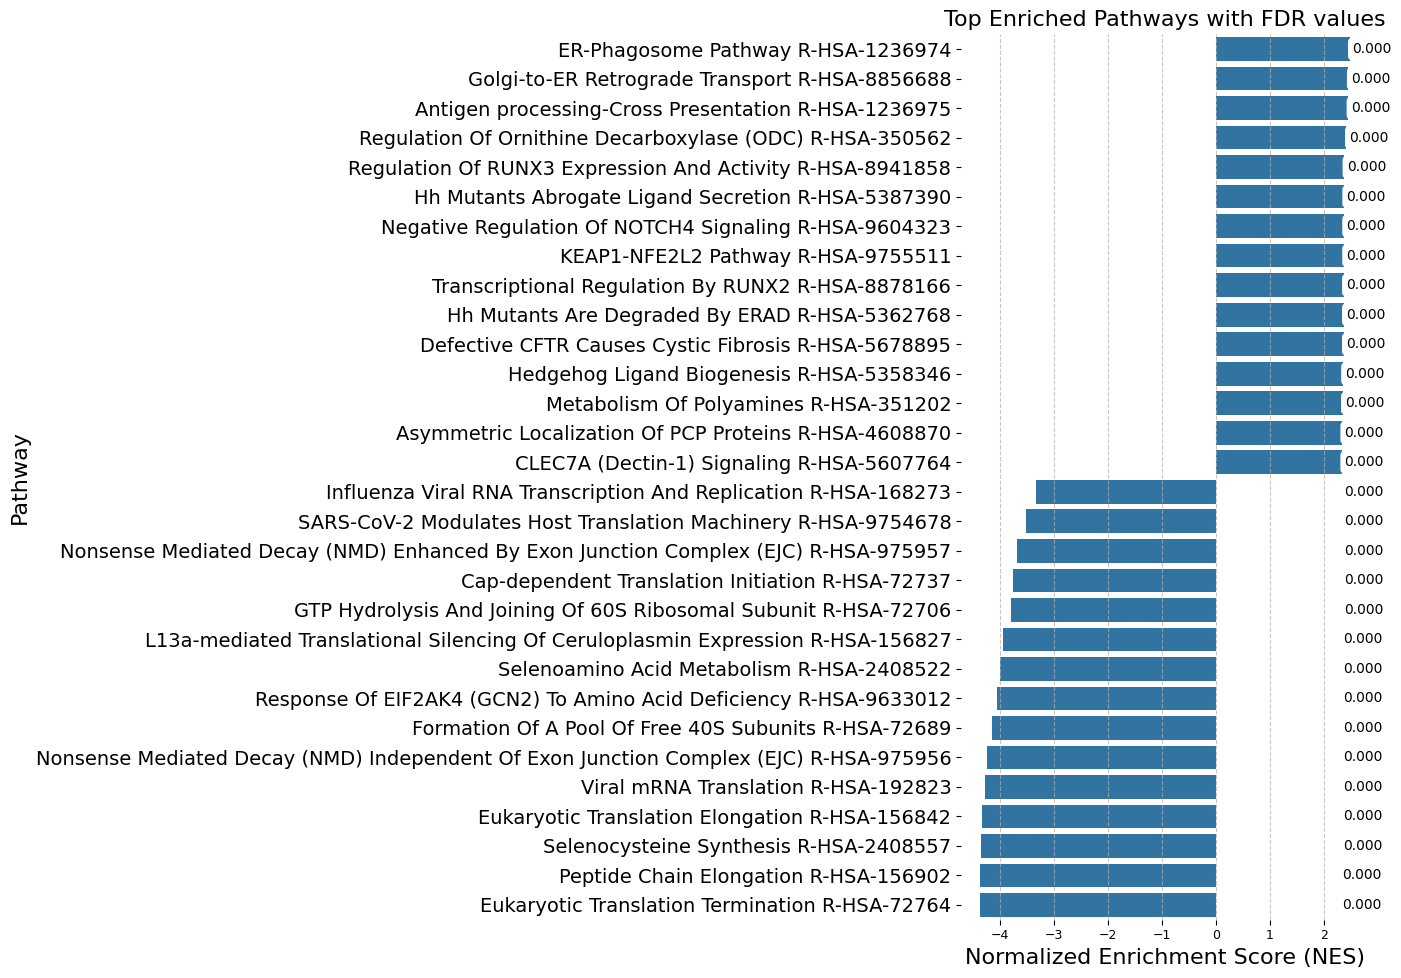

In [71]:
gsea_results = res_p_REA.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val', 'Lead_genes', 'Tag %', 'Gene %']].sort_values('NES', ascending=False)

plt.figure(figsize=(14, 10))  
barplot = sns.barplot(x='NES', y='Term', data = pd.concat([gsea_results.head(15), gsea_results.tail(15)]))


for index, value in enumerate(gsea_results.head(30)['FDR q-val']):
    barplot.text(gsea_results.head(30)['NES'].iloc[index] + 0.05, index, f'{value:.3f}', color='black', ha="left", va="center", fontsize=10, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))


plt.xlabel('Normalized Enrichment Score (NES)')
plt.ylabel('Pathway')
plt.title('Top Enriched Pathways with FDR values')


sns.despine(left=True, bottom=True)  
plt.grid(axis='x', linestyle='--', alpha=0.7)
#barplot.set(xticks=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2.0, 2.25])
plt.tight_layout()  


plt.show()

Tasks 
* cnetplot pre reactome gsea
* rozdelit Csp HKSEL geny do subsetov
* stale zistit co su tie 0 p vals
* do jednej figure zhrnut celu moju analyz

biorender/kreslenie rukou 

1. 1a shcema work processu/work pipeline 
2. 1a supplementary gating aj fitting
3. 1b go enrichement barchart 5 pos 5 neg
4. 1c cnet plot z go
5. 1d bar chart reactome
6. 1e gsea plot plasma to co si robil teraz 

Remarks
* top positive znamena ze geny zvysuju svoju translaciu v bunkach ktore stupaju
* top negative znamena ze geny znizuju 

In [72]:
list_genes = list(correlation_df_spearman_sorted.index)

In [73]:
genes_str = "\n".join(list_genes)
genes_str_rev = "\n".join(list_genes[::-1])

In [74]:
#with open("spearman_rev.txt", "w") as file:
#    file.write(genes_str_rev)

#### Exosome gene parsing and GSEAPrerank

In [75]:
def parse_genes(file):
    df = pd.read_excel(file)
    df.T.reset_index(drop=True).T
    HKSA, CPG = df.iloc[:, 2].dropna(), df.iloc[:, 4].dropna()
    HKSA = [re.findall(r'\(([A-Za-z0-9\-\_]+)\)', str(gene_description))[-1] for gene_description in HKSA]
    CPG = [re.findall(r'\(([A-Za-z0-9\-\_]+)\)', str(gene_description))[-1] for gene_description in CPG]
    HKSA = [gene.upper() for gene in set(HKSA)]
    CPG = [gene.upper() for gene in set(CPG)]
    return HKSA, CPG

In [76]:
HKSA_SUP1, CPG_SUP1 = parse_genes("suplemental_1_parsed.xlsx")
HKSA_SUP2, CPG_SUP2 = parse_genes("suplemental_2_parsed.xlsx")
HKSA_SUP3, CPG_SUP3 = parse_genes("suplemental_3_parsed.xlsx")


In [77]:
gene_set = {
    "EXOSOME_GENES_SUPP1_HKSA": HKSA_SUP1,
    "EXOSOME_GENES_SUPP1_CPG": CPG_SUP1,
    "EXOSOME_GENES_SUPP2_HKSA": HKSA_SUP2,
    "EXOSOME_GENES_SUPP2_CPG": CPG_SUP2,
    "EXOSOME_GENES_SUPP3_HKSA": HKSA_SUP3,
    "EXOSOME_GENES_SUPP3_CPG": CPG_SUP3
}
gsea_supplemental_sep = gp.prerank(rnk=correlation_df_spearman_sorted, 
                         gene_sets=gene_set, 
                         outdir='prerank_output_supp_separated_CPG_HKSA_separated_v0', 
                         organism='Human', 
                         permutation_num=1000,
                         verbose=True)

2025-02-10 14:52:13,999 [WARNING] Duplicated values found in preranked stats: 70.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-02-10 14:52:14,000 [INFO] Parsing data files for GSEA.............................
2025-02-10 14:52:14,006 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-02-10 14:52:14,008 [INFO] 0006 gene_sets used for further statistical testing.....
2025-02-10 14:52:14,009 [INFO] Start to run GSEA...Might take a while..................
2025-02-10 14:52:21,625 [INFO] Start to generate gseapy reports, and produce figures...
2025-02-10 14:52:21,626 [INFO] Congratulations. GSEApy runs successfully................



#### Remarks and thoughts

7.3. Q: Why P-value or FDR is 0, not a very small number?
A: GSEA methodology use random permutation procedure (e.g. 1000 permutation) to obtain a null distribution. Then, an observed ES is compared to the 1000 shuffled ES to calculate a P-value. When observed ES is not within the null ESs, you’ll get 0s. if you don’t want 0, you could

set the smallest pvalue to 1 / ( number of permutations)

increase the permutation number (but more running time needed)